In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
!pip install pycaret-nightly
!pip install missingno
!pip install captum

     |████████████████████████████████| 300 kB 2.3 MB/s            
     |████████████████████████████████| 24.2 MB 53.8 MB/s            
     |████████████████████████████████| 10.4 MB 50.9 MB/s            
     |████████████████████████████████| 167 kB 77.6 MB/s            
     |████████████████████████████████| 25.9 MB 50.6 MB/s            
     |████████████████████████████████| 636 kB 76.5 MB/s            
     |████████████████████████████████| 114 kB 73.1 MB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 15.5 MB 29.2 MB/s            
     |████████████████████████████████| 1.0 MB 40.0 MB/s            
     |████████████████████████████████| 184 kB 52.5 MB/s            
     |████████████████████████████████| 79 kB 6.1 MB/s             
     |████████████████████████████████| 58 kB 4.8 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 1.1 MB 46.5 MB/s            
  Preparing 

<hr style="border: solid 3px blue;">

# Introduction

![](https://i.gifer.com/9JKP.gif)

Picture Credit: https://i.gifer.com

**In this notebook, we would like to organize them in the following order:**
> **Detailed EDA and preprocessing:** During this process, it also includes the process of outlier detection using PCA and prediction of future house price using prophet.
>
> **Deep Learning:** Design a model using a neural network, train and predict. Also, check the feature importance from the point of view of the designed model.
>
> **Classic ML:** Learn classic ML models using the ensemble model and make predictions using them. After that, check the feature importance.

# Setting up

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from matplotlib import rcParams
import torch
import torch.nn as nn
import torch.optim as optim
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

In [4]:
PATH = '../input/house-prices-advanced-regression-techniques'
train = pd.read_csv(PATH+'/train.csv')
X_test = pd.read_csv(PATH+'/test.csv')
submission_data = pd.read_csv(PATH+'/sample_submission.csv')

In [5]:
house_df = pd.concat([train,X_test],ignore_index = True, sort = False)
tr_idx = house_df['SalePrice'].notnull()

--------------------------------------------------------------
## Utility Functions

In [6]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [7]:
def outlier_iqr(data):
    q1,q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lower = q1-(iqr*2)
    upper = q3+(iqr*2)
    return np.where((data>upper)|(data<lower))

--------------------------------------------------
# EDA

In [8]:
house_df.head(3).style.set_properties(**{'background-color': 'Grey',
                           'color': 'white',
                           'border-color': 'darkblack'})

**Id feature is simply unique ID, so it is not helpful for learning. Let's remove it.**

In [9]:
house_df.drop('Id',axis=1,inplace=True,errors='ignore')

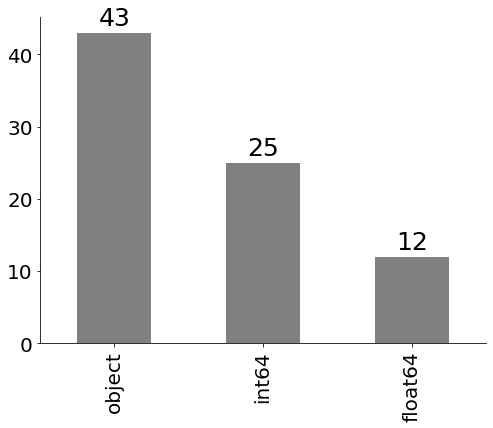

In [10]:
plt.figure(figsize = (8,6))
ax = house_df.dtypes.value_counts().plot(kind='bar',grid = False,fontsize=20,color='grey')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 1, height, ha = 'center', size = 25)
sns.despine()

<span style="color:Blue"> Observation:

There are 37 numerical features and 43 object (string) types.
Among the numeric features, 25 are int types and 12 are float types.
There must be a reason for using a different type like this. Let's check some more.

# Categorizing Columns

In [11]:
categorical_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns]

# Select numerical columns
int_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if 
                house_df[cname].dtype in ['int64']]
float_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if 
                house_df[cname].dtype in ['float64']]

numerical_cols = int_cols + float_cols

## Checking Missing Values

<AxesSubplot:>

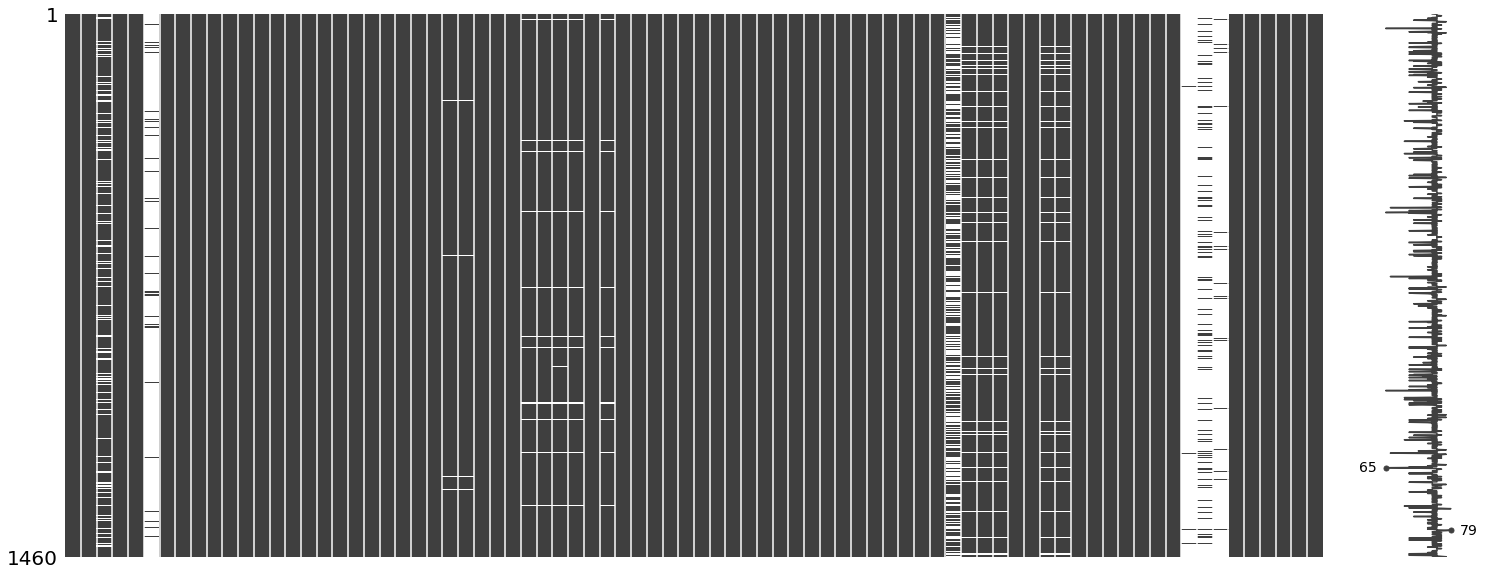

In [12]:
import missingno as msno
msno.matrix(house_df[tr_idx])

## Imputing Numerical Missing Valuse

Since it is a regression problem, filling it with KNN seems to be a wise choice.

> Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

Ref: https://scikit-learn.org/stable

In [13]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
house_df.loc[:,numerical_cols] = imputer.fit_transform(house_df.loc[:,numerical_cols])

## Checking Categorical Missing Values

Numerical missing values were filled in. Let's check again what the remaining missing values are.

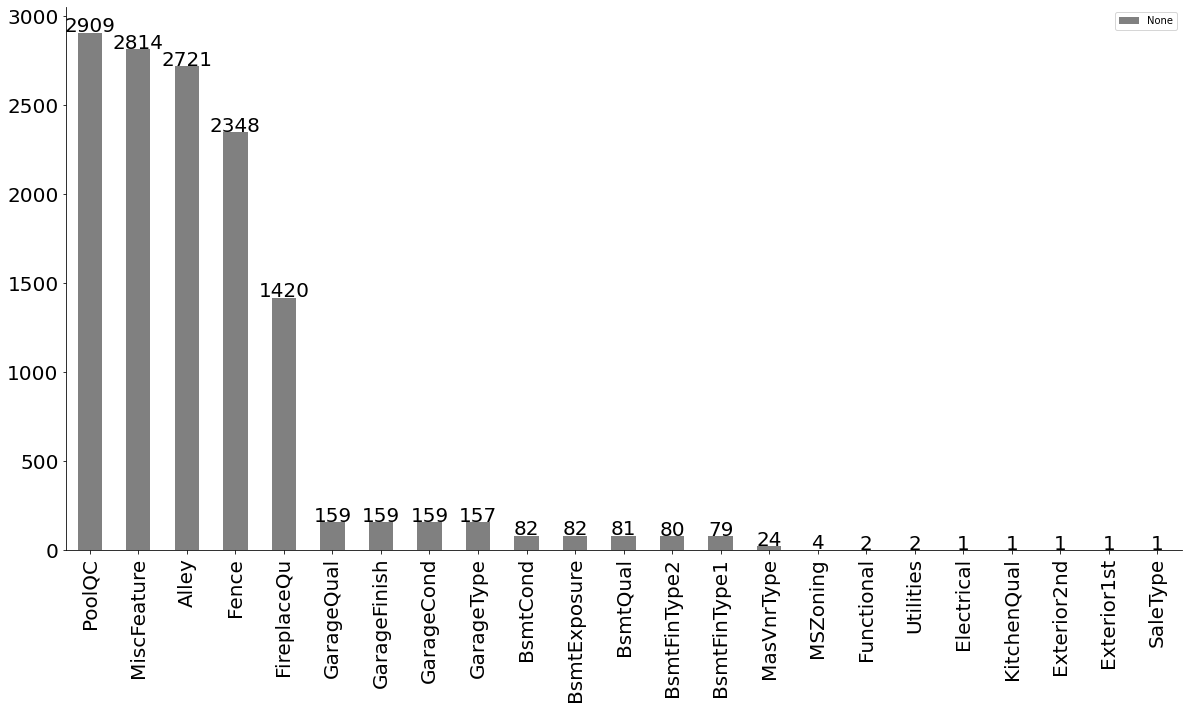

In [14]:
isnull_series = house_df.loc[:,:'SaleCondition'].isnull().sum()
isnull_series[isnull_series > 0].sort_values(ascending=False)

plt.figure(figsize = (20,10))
ax = isnull_series[isnull_series > 0].sort_values(ascending=False).plot(kind='bar',
                                                                        grid = False,
                                                                        fontsize=20,
                                                                        color='grey')
plt.legend(loc = 'upper right')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 5, height, ha = 'center', size = 20)
sns.despine()

<span style="color:Blue"> Observation:
    
* PoolQC, MiscFeature, Alley, Fence, and FireplaceQu features have too many missing values.
* Garage-related features have 157 to 159 missing values. It is unknown whether the houses lacked garages or were intentionally omitted.
* Basement-related features also have 79 to 82 missing values.
It seems that we need to focus more on the process of filling in the missing values ​​of the corresponding Garage and Basement features.

----------------------------------------------------------
# Checking Target

The problem is a regression problem. Therefore, we analyze the distribution of the target and check whether there is necessary preprocessing based on this. If it is a classification problem
We need to check target imbalance.

SalePrice : mean: 180921.1959, std: 79442.5029, skew: 1.8829


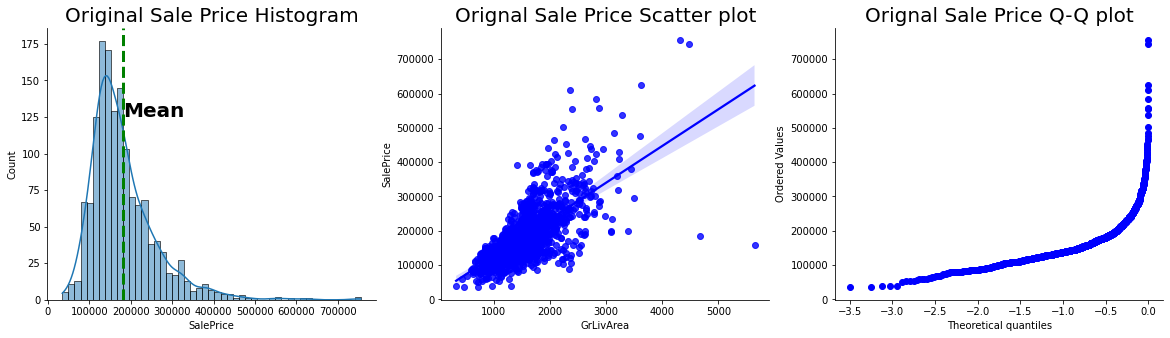

In [15]:
plt.figure(figsize = (20,5))
ax1 = plt.subplot(1,3,1)
sns.histplot(house_df['SalePrice'],palette='Blues_r',kde=True)
ax1.axvline(x=house_df['SalePrice'].mean(), color='g', linestyle='--', linewidth=3)
ax1.text(house_df['SalePrice'].mean(), 125, "Mean", horizontalalignment='left', size=20, color='black', weight='semibold')
ax1.set_title('Original Sale Price Histogram',fontsize=20)
ax2 = plt.subplot(1,3,2)
sns.regplot(data=house_df, y="SalePrice", x="GrLivArea",ax=ax2,color='Blue')
ax2.set_title('Orignal Sale Price Scatter plot',fontsize=20)
ax3 = plt.subplot(1,3,3)
stats.probplot(house_df['SalePrice'],dist = stats.norm, plot = ax3)
ax3.set_title('Orignal Sale Price Q-Q plot',fontsize=20)
sns.despine()

mean = house_df['SalePrice'].mean()
std = house_df['SalePrice'].std()
skew = house_df['SalePrice'].skew()
print('SalePrice : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

<span style="color:Blue"> Observation:

The skewness was about 1.88. Also, since the metric is RMSLE, we will perform log scaling.

In [16]:
house_df['SalePriceCpy'] = np.log1p(house_df['SalePrice'])

SalePrice : mean: 12.0241, std: 0.3994, skew: 0.1213


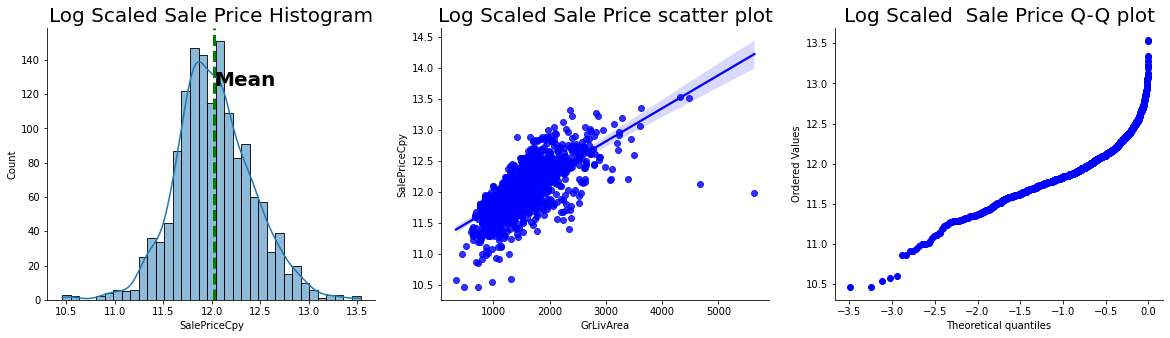

In [17]:
plt.figure(figsize = (20,5))
ax1 = plt.subplot(1,3,1)
sns.histplot(house_df['SalePriceCpy'],palette='Blues_r',kde=True)
plt.axvline(x=house_df['SalePriceCpy'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(house_df['SalePriceCpy'].mean(), 125, "Mean", horizontalalignment='left', size=20, color='black', weight='semibold')
plt.title('Log Scaled Sale Price Histogram',fontsize=20)
ax2 = plt.subplot(1,3,2)
sns.regplot(data=house_df, y="SalePriceCpy", x="GrLivArea",ax=ax2,color='Blue')
ax2.set_title('Log Scaled Sale Price scatter plot',fontsize=20)
ax3 = plt.subplot(1,3,3)
stats.probplot(house_df['SalePriceCpy'],plot = ax3)
ax3.set_title('Log Scaled  Sale Price Q-Q plot',fontsize=20)
sns.despine()

mean = house_df['SalePriceCpy'].mean()
std = house_df['SalePriceCpy'].std()
skew = house_df['SalePriceCpy'].skew()
print('SalePrice : mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}'.format(mean, std, skew))

> Logarithm function increases the spacing between small numbers and reduces the spacing between large numbers. When certain features are dense with values in small values, by increasing these intervals, our models increase the intervals for small values, and we can improve the performance of the model when training and testing using these values.

Ref: https://www.kaggle.com/ohseokkim/preprocessing-linear-nonlinear-scaling

<span style="color:Blue"> Observation:
    
* If you look at the regression plot between GrLivArea and SalePrice, you can see that a clearer regression line is drawn after conversion. Log transform will definitely help with learning.
* Skewness was also improved.    

In [18]:
house_df.drop('SalePriceCpy',axis=1,inplace=True,errors='ignore')

---------------------------------------------------------------------------
# Doing EDA for Numerical Features

![](https://static-assets.codecademy.com/Courses/Hypothesis-Testing/Intro_to_variable_types_4.png)

Picture Credit: https://t3.ftcdn.net

-----------------------------------------------------------------------------
## Continous Features

Continuous variables are numeric variables that have an infinite number of values between any two values. A continuous variable can be numeric or date/time. For example, the length of a part or the date and time a payment is received.

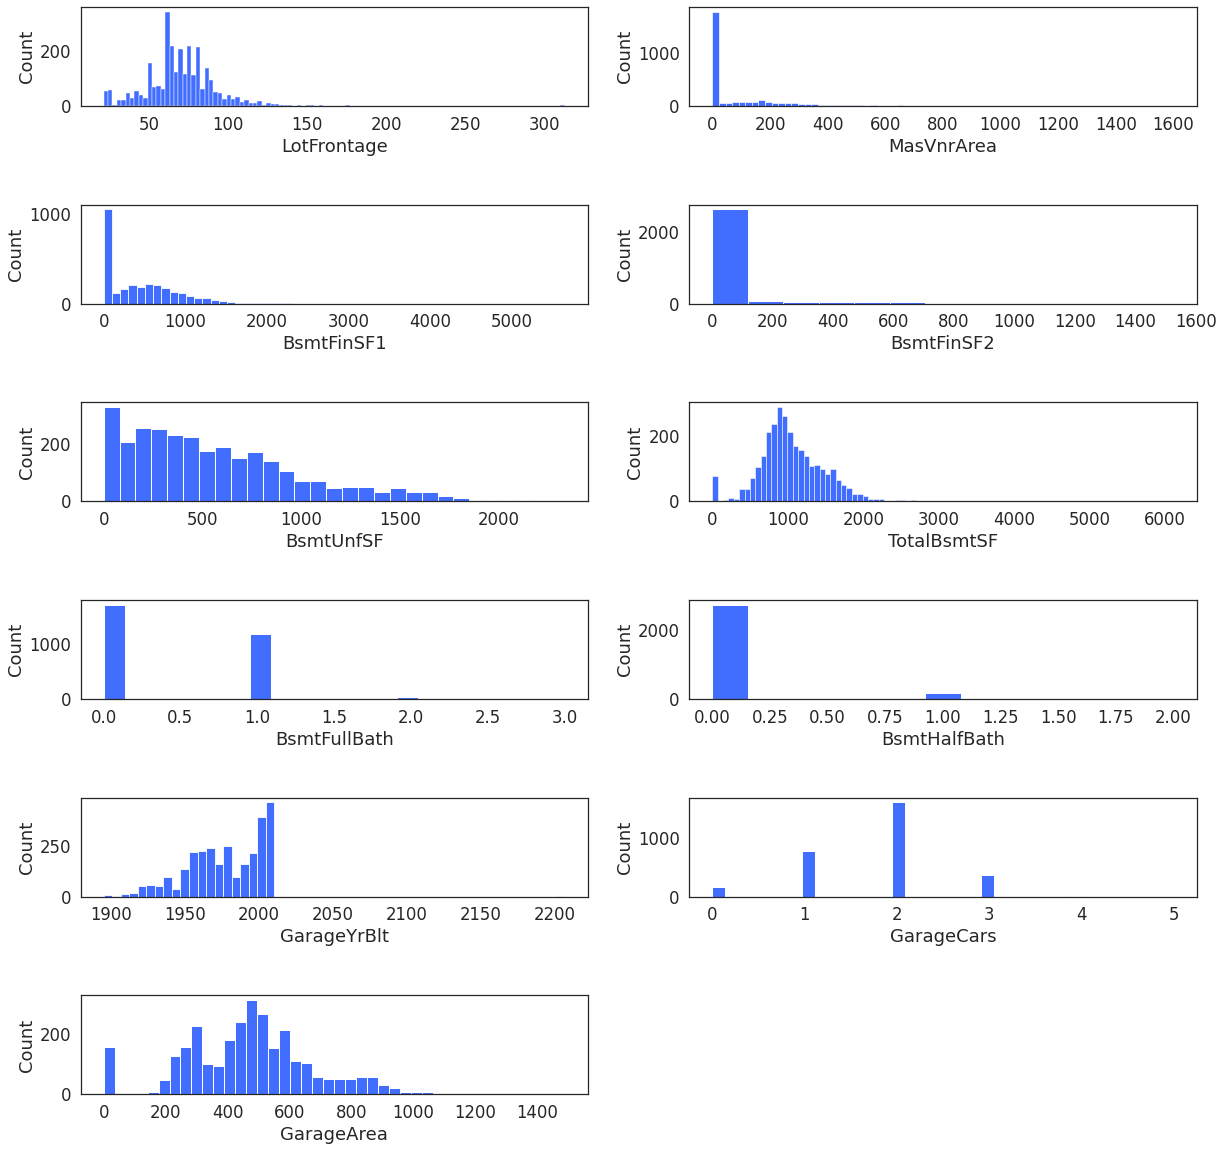

In [19]:
i = 1
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=1)
for feature in float_cols:
    plt.subplot(6,2,i)
    sns.histplot(house_df[feature], palette='Blues_r')
    i = i +1

<span style="color:Blue"> Observation:
    
* GarageCars, BsmtHalfBath, BsmtFullBath and GarageCars are discrete variables.
* Some features have a skewed shape to one side.

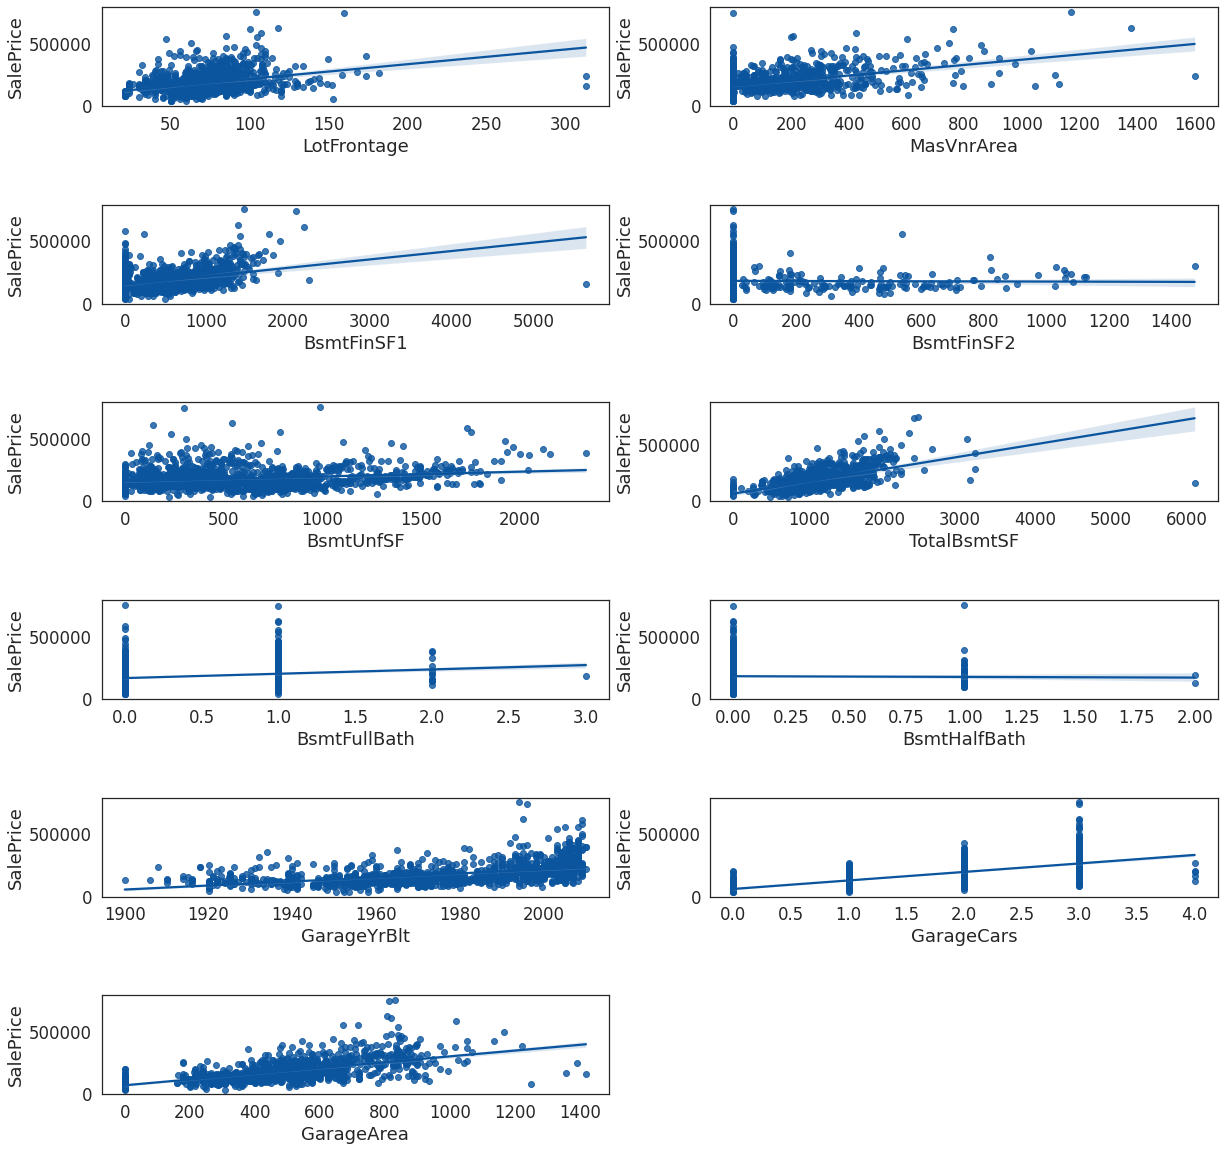

In [20]:
i = 1
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=1)
for feature in float_cols:
    plt.subplot(6,2,i)
    sns.regplot(data=house_df, x=feature,y='SalePrice')
    i = i +1

<span style="color:Blue"> Observation:
    
It seems that there are outliers that deviate from the regression line. Let's check some more.

-------------------------------------------
## Discrete Features

Discrete variables are numeric variables that have a countable number of values between any two values. A discrete variable is always numeric. For example, the number of customer complaints or the number of flaws or defects.

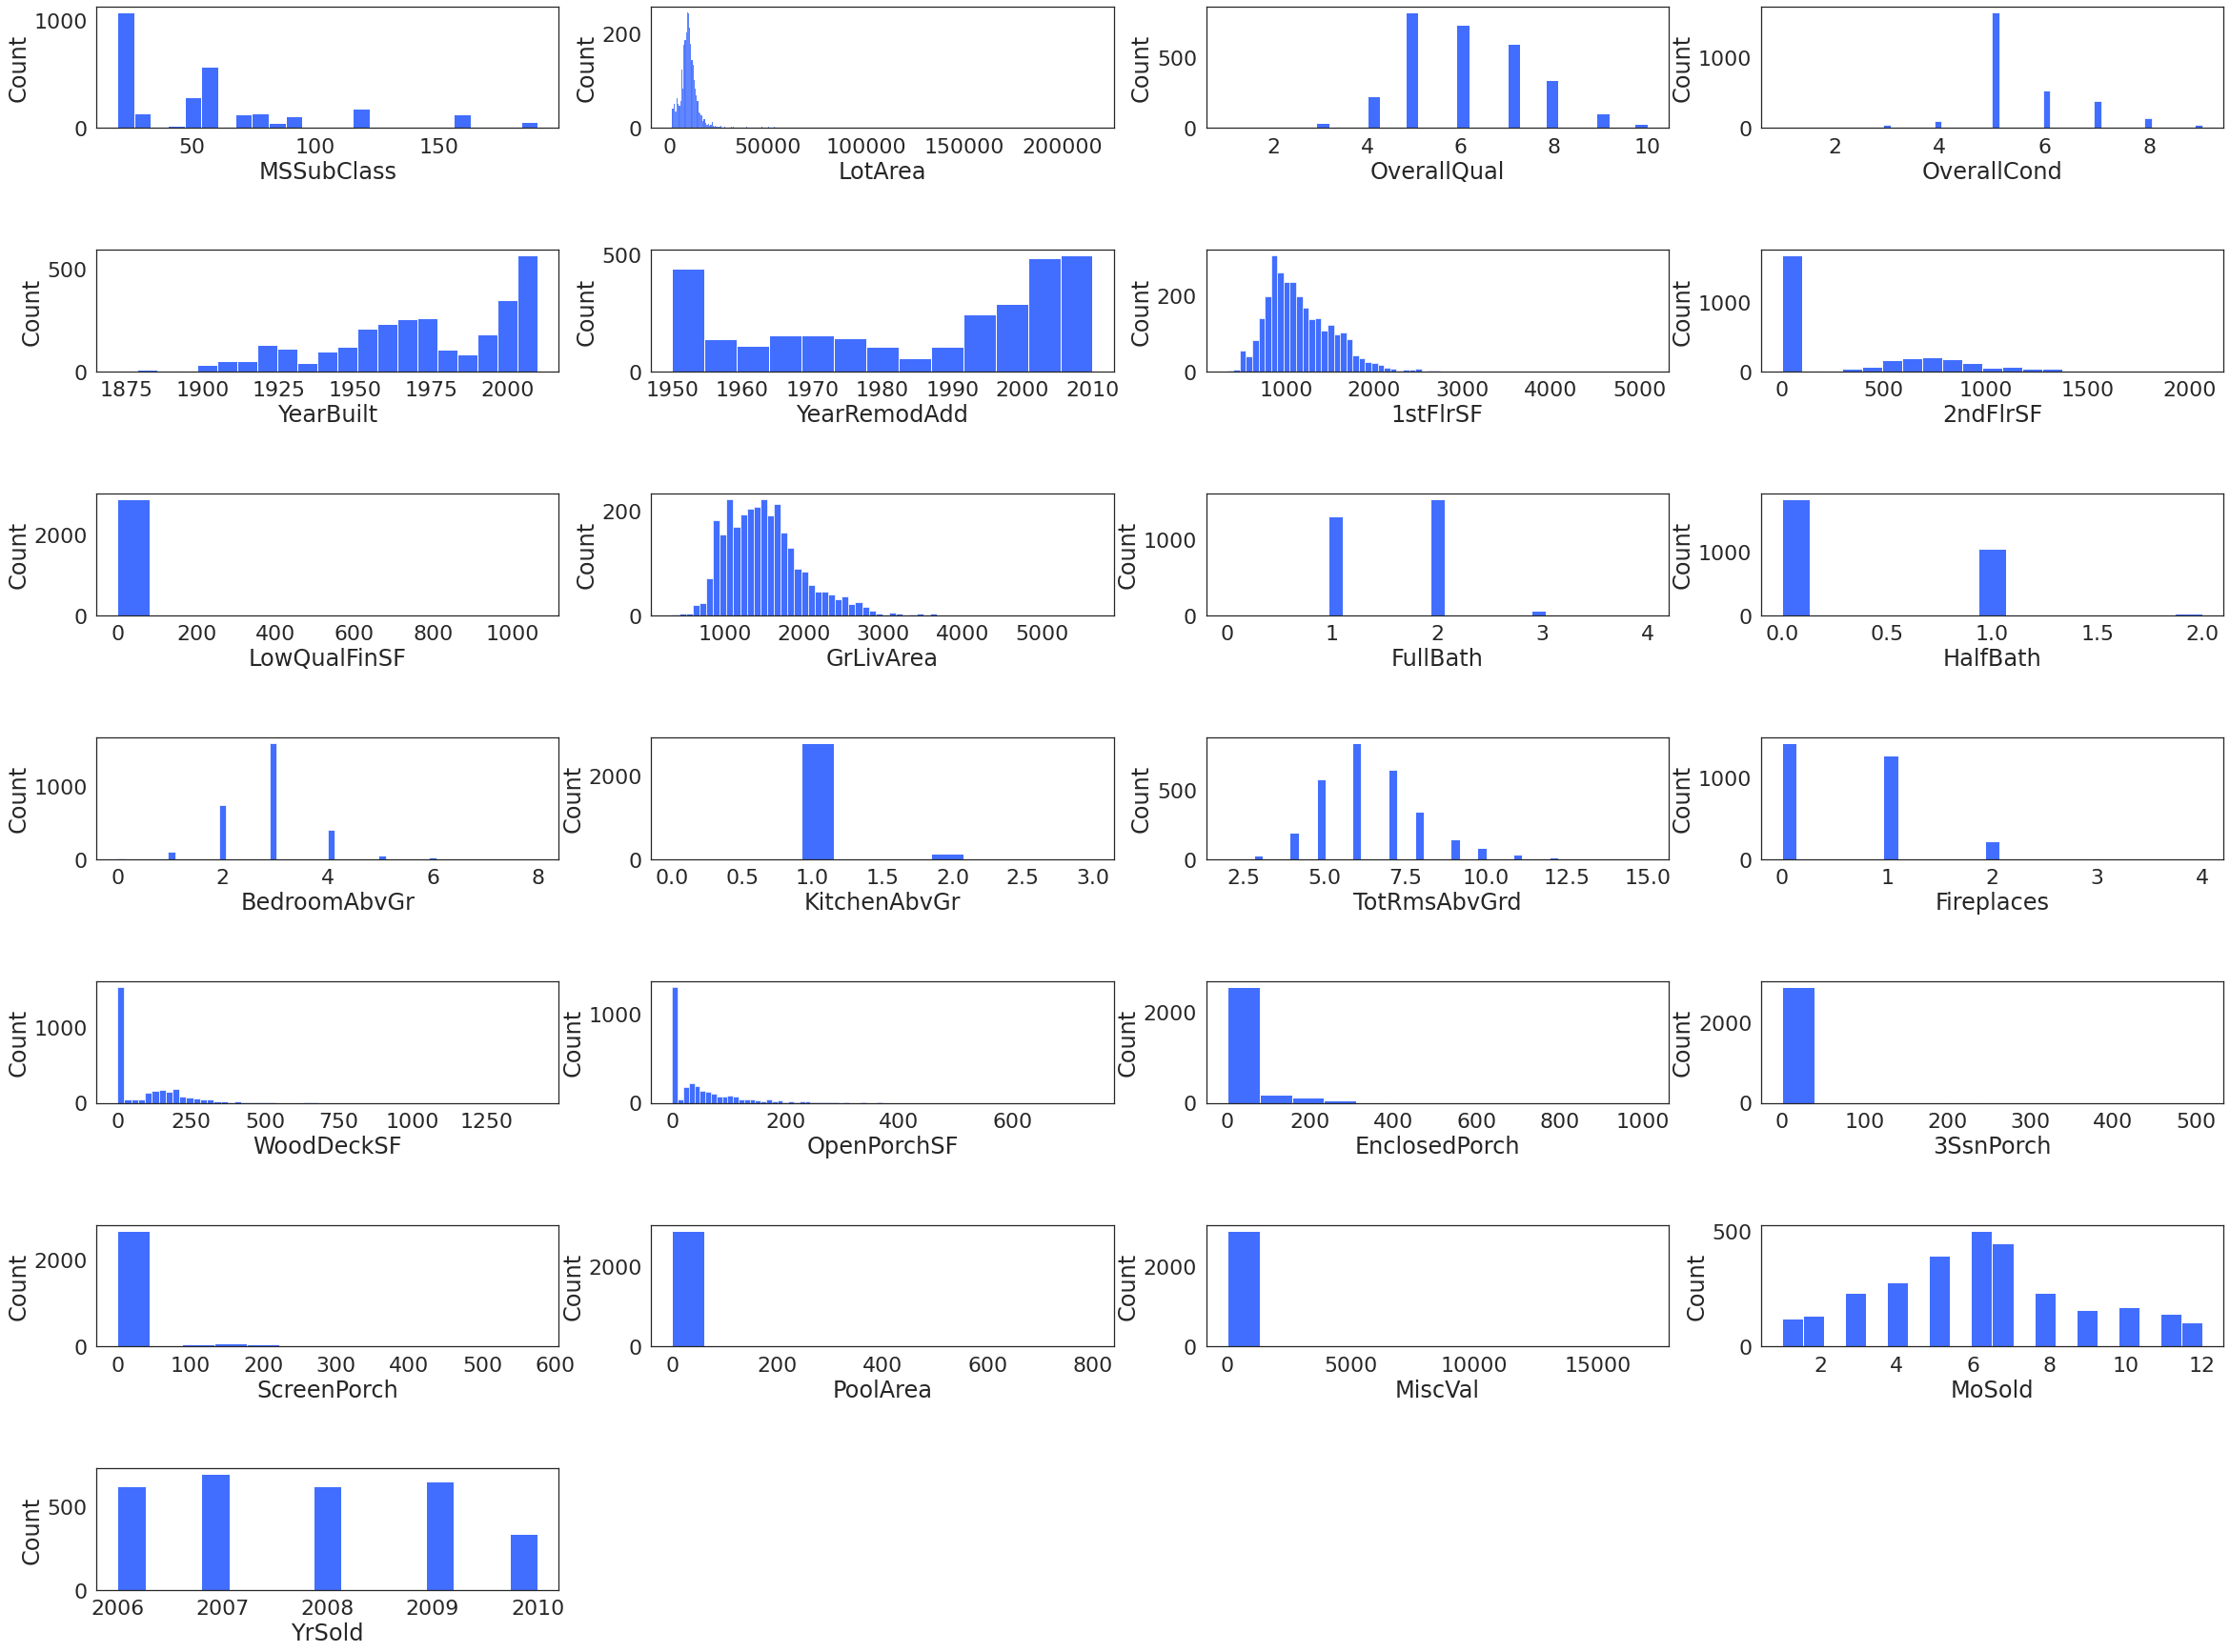

In [21]:
i = 1
sns.set(font_scale = 2)
sns.set_style("white")
sns.set_palette("bright")
plt.figure(figsize=(40, 40))
plt.subplots_adjust(hspace=1)
for feature in int_cols:
    plt.subplot(9,4,i)
    sns.histplot(house_df[feature], palette='Blues_r')
    i = i +1

In the regression problem, discrete and non-order features must be converted to one-hot encoding. 

In [22]:
house_df['MSSubClass'] = house_df['MSSubClass'].apply(str)
house_df['YrSold'] = house_df['YrSold'].astype(str)
house_df['MoSold'] = house_df['MoSold'].astype(str)

----------------------------------
# Let's predict future house price

![](https://insightimi.files.wordpress.com/2020/07/on-de793_201909_g_20190830121038.gif)

Picture Credit: https://insightimi.files.wordpress.com

Now, let's use the YearBuilt and YearRemodAdd features to predict the future house price using prophet.

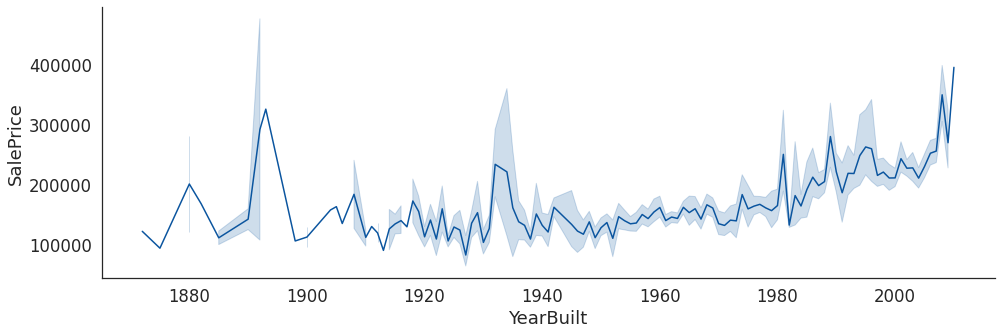

In [23]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(16,5))
sns.lineplot(data=house_df, x='YearBuilt',y='SalePrice')
sns.despine()

In [24]:
house_yearbuilt_ds = pd.to_datetime(house_df[tr_idx].YearBuilt,format='%Y')
house_yearbuild_df = pd.concat([house_df.SalePrice[tr_idx],house_yearbuilt_ds],axis=1)
house_yearbuild_df.rename(columns={"SalePrice": "y","YearBuilt":"ds"},inplace=True)

In [25]:
from fbprophet import Prophet 
m = Prophet()
m.fit(house_yearbuild_df)

Initial log joint probability = -32.3428
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2860.95   2.45615e-05       57.7854    0.006396           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       2861.02   5.67637e-05       46.6115   1.185e-06       0.001      224  LS failed, Hessian reset 
     124       2861.04    0.00012124       56.3055   3.287e-06       0.001      267  LS failed, Hessian reset 
     139       2861.05   7.02216e-07       52.7839   1.943e-08       0.001      332  LS failed, Hessian reset 
     147       2861.05   8.19166e-08       56.2457      0.2429           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [26]:
future = m.make_future_dataframe(periods=2000)
forecast = m.predict(future)

In [27]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

In [28]:
plot_components_plotly(m, forecast)

<span style="color:Blue"> Observation:
    
If you look at the picture above, the more recently built the house, the higher the price.

-----------------------------

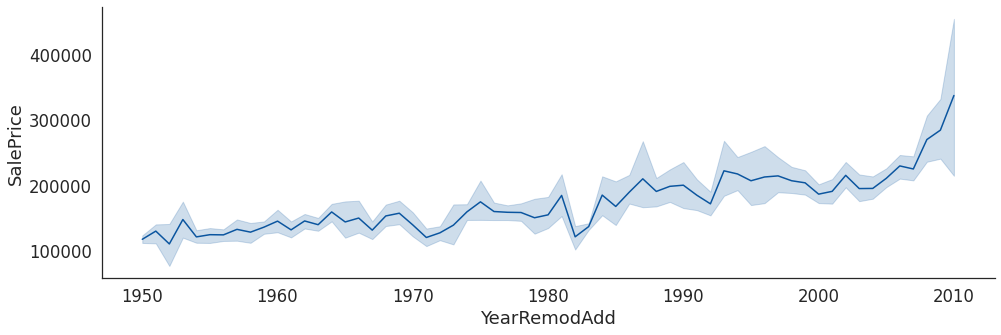

In [29]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(16,5))
sns.lineplot(data=house_df, x='YearRemodAdd',y='SalePrice')
sns.despine()

In [30]:
house_YearRemodAdd_ds = pd.to_datetime(house_df[tr_idx].YearRemodAdd,format='%Y')
house_YearRemodAdd_df = pd.concat([house_df.SalePrice[tr_idx],house_YearRemodAdd_ds],axis=1)
house_YearRemodAdd_df.rename(columns={"SalePrice": "y","YearRemodAdd":"ds"},inplace=True)

In [31]:
m = Prophet()
m.fit(house_YearRemodAdd_df)

Initial log joint probability = -14.5543


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2782.93   9.93386e-05       145.912     0.06682           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       2783.09   1.25457e-05       83.0016    1.44e-07       0.001      301  LS failed, Hessian reset 
     199       2783.09   5.33787e-08       76.4449     0.04622     0.04622      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243        2783.1   3.75327e-07       57.7373     0.07186           1      369   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [32]:
future = m.make_future_dataframe(periods=2000)
forecast = m.predict(future)

In [33]:
plot_plotly(m, forecast)

In [34]:
plot_components_plotly(m, forecast)

<span style="color:Blue"> Observation:
    
The more recently remodeled the house, the higher the house price.

------------------------------------------------------------------------
## Checking Outliers

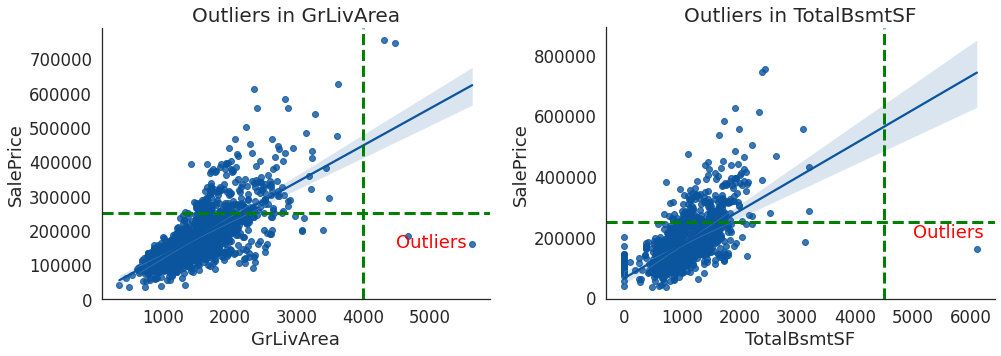

In [35]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.3)
ax1 = sns.regplot(data=house_df, x='GrLivArea',y='SalePrice')
ax1.set_title('Outliers in GrLivArea',fontsize=20)
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4500, 150000, 'Outliers',color='red')
plt.subplot(1,2,2)
ax2 = sns.regplot(data=house_df, x='TotalBsmtSF',y='SalePrice')
ax2.set_title('Outliers in TotalBsmtSF',fontsize=20)
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4500, color='Green', linestyle='--', linewidth=3)
plt.text(5000, 200000, 'Outliers',color='red')
sns.despine()

<span style="color:Blue"> Observation:

If you look at the picture above, you can see an outlier. Regression models are sensitive to outliers, so it is better to remove them. Outlier is like gravity. It pulls the regression line. Therefore, it is better to remove outliers.
However, it is not easy to judge an outlier. Domain knowledge may also be required to remove outliers.

-----------------------------------------------------------------------
# Detecting Outliers by PCA

![](https://joachim-gassen.github.io/images/ani_sim_vert_outlier.gif)

Picture Credit: https://joachim-gassen.github.io/images/ani_sim_vert_outlier.gif

The more features, the higher the dimension. When projecting to a lower dimension through PCA, new insights can be gained. PCA can effectively detect outliers. Let's apply PCA to this problem and check whether the detection actually confirmed by the eye is also detected through PCA.

In other words, let's reduce the dimension, check the things that are judged as outliers in the reduced dimension, and check whether the row is an outlier for some reason.

**Looking at the figure above, PC 1 has the largest variance in the dataset distribution. That is, the outlier in PC 1 is very likely to be an outlier that needs to be removed from the dataset.
For this reason, there is a high possibility that an outlier to be removed is detected in PC 2 as well.**

In [36]:
features = ["GarageArea","OverallQual","TotalBsmtSF","GrLivArea"]

In [37]:
house_copy = house_df[tr_idx].copy()
y_copy = house_copy.pop("SalePrice")
X_copy = house_copy.loc[:, features]

X_copy.isnull().sum()
pca, X_pca, loadings = apply_pca(X_copy)

In [38]:
import plotly.express as px
fig = px.histogram(X_pca[['PC1','PC2']].melt(), color="variable", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="white",
    legend_title_font_color="yellow",
    title={
        'text': "PCA Histogram",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)

<span style="color:Blue"> Observation:
    
The order of distribution size for each PC is PC1->PC2. Since the process of finding a PC through PCA is to find a direction vector with the largest variance, this result is self-evident.
    
Based on the boxplot, there are outliers for each PC. Let's check further if it makes sense to remove those values.

-----------------------------------------------------------------
## The Fist Principal Component

After PCA, if you draw histogram and box plot for each comment, IQR based outliers are visible.



In [39]:
pc1_outlier_idx = list(outlier_iqr(X_pca['PC1'])[0])

In [40]:
component = "PC1"

pc1_idx = X_pca[component].sort_values(ascending=False).index
df_temp_pc1 = house_df.loc[pc1_idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

df_temp_pc1.iloc[pc1_outlier_idx,:].style.set_properties(**{'background-color': 'Grey',
                            'color': 'white',
                            'border-color': 'darkblack'})

11 outliers were detected as the first principal component.

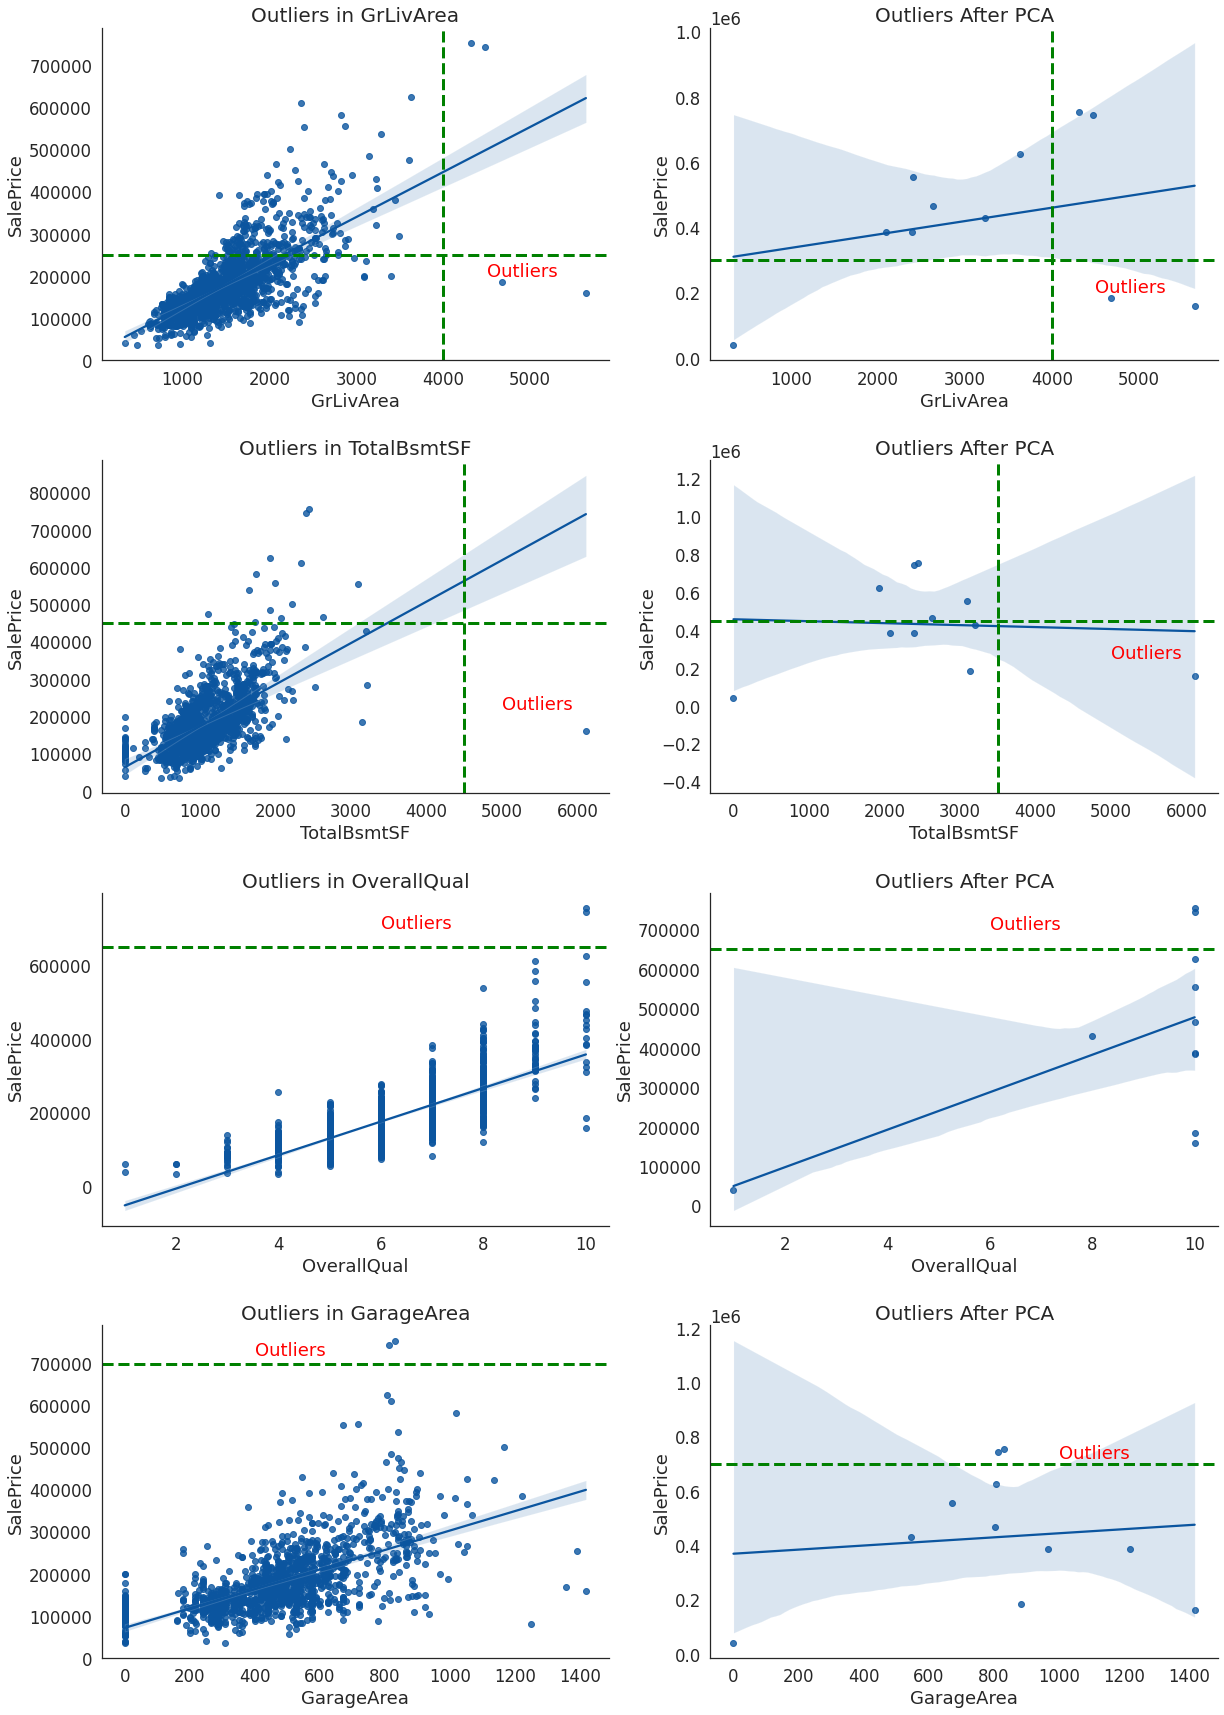

In [41]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.3)
plt.subplot(4,2,1)
ax1 = sns.regplot(data=house_df, x='GrLivArea',y='SalePrice')
ax1.set_title('Outliers in GrLivArea',fontsize=20)
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4500, 200000, 'Outliers',color='red')
plt.subplot(4,2,2)
ax2 = sns.regplot(data=house_df.iloc[pc1_outlier_idx,:], x='GrLivArea',y='SalePrice')
ax2.set_title('Outliers After PCA',fontsize=20)
plt.axhline(y=300000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4500, 200000, 'Outliers',color='red')
plt.subplot(4,2,3)
ax3 = sns.regplot(data=house_df, x='TotalBsmtSF',y='SalePrice')
ax3.set_title('Outliers in TotalBsmtSF',fontsize=20)
plt.axhline(y=450000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4500, color='Green', linestyle='--', linewidth=3)
plt.text(5000, 220000, 'Outliers',color='red')
plt.subplot(4,2,4)
ax4 = sns.regplot(data=house_df.iloc[pc1_outlier_idx,:], x='TotalBsmtSF',y='SalePrice')
ax4.set_title('Outliers After PCA',fontsize=20)
plt.axhline(y=450000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=3500, color='Green', linestyle='--', linewidth=3)
plt.text(5000, 250000, 'Outliers',color='red')
plt.subplot(4,2,5)
ax5 = sns.regplot(data=house_df, x='OverallQual',y='SalePrice')
ax5.set_title('Outliers in OverallQual',fontsize=20)
plt.axhline(y=650000, color='Green', linestyle='--', linewidth=3)
plt.text(6, 700000, 'Outliers',color='red')
plt.subplot(4,2,6)
ax6 = sns.regplot(data=house_df.iloc[pc1_outlier_idx,:], x='OverallQual',y='SalePrice')
ax6.set_title('Outliers After PCA',fontsize=20)
plt.axhline(y=650000, color='Green', linestyle='--', linewidth=3)
plt.text(6, 700000, 'Outliers',color='red')
plt.subplot(4,2,7)
ax7 = sns.regplot(data=house_df, x='GarageArea',y='SalePrice')
ax7.set_title('Outliers in GarageArea',fontsize=20)
plt.axhline(y=700000, color='Green', linestyle='--', linewidth=3)
plt.text(400, 720000, 'Outliers',color='red')
plt.subplot(4,2,8)
ax8 = sns.regplot(data=house_df.iloc[pc1_outlier_idx,:], x='GarageArea',y='SalePrice')
ax8.set_title('Outliers After PCA',fontsize=20)
plt.axhline(y=700000, color='Green', linestyle='--', linewidth=3)
plt.text(1000, 720000, 'Outliers',color='red')
sns.despine()

<span style="color:Blue"> Observation:
    
Looking at the figure above, points that are clearly judged as outliers in the figures on the left are also judged as outliers in PC1 after PCA.
That is, outlier judgment using PCA seems very effective.

-------------------------------------
## The Second Principal Component

In [42]:
pc2_outlier_idx = list(outlier_iqr(X_pca['PC2'])[0])

In [43]:
component = "PC2"

pc2_idx = X_pca[component].sort_values(ascending=False).index
df_temp_pc2 = house_df.loc[pc2_idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

df_temp_pc2.iloc[pc2_outlier_idx,:].style.set_properties(**{'background-color': 'Grey',
                            'color': 'white',
                            'border-color': 'darkblack'})

<span style="color:Blue"> Observation:
    
There is only one outlier detected as the second Principal Component.

---------------------------
## Removing Outlier using PCA

In [44]:
house_df.drop(pc1_outlier_idx,axis=0,inplace=True,errors='ignore')
house_df.drop(pc2_outlier_idx,axis=0,inplace=True,errors='ignore')

**Let's remove the outliers detected above.**

----------------------------------------------------------------
## Checking Outliers after removing outliers

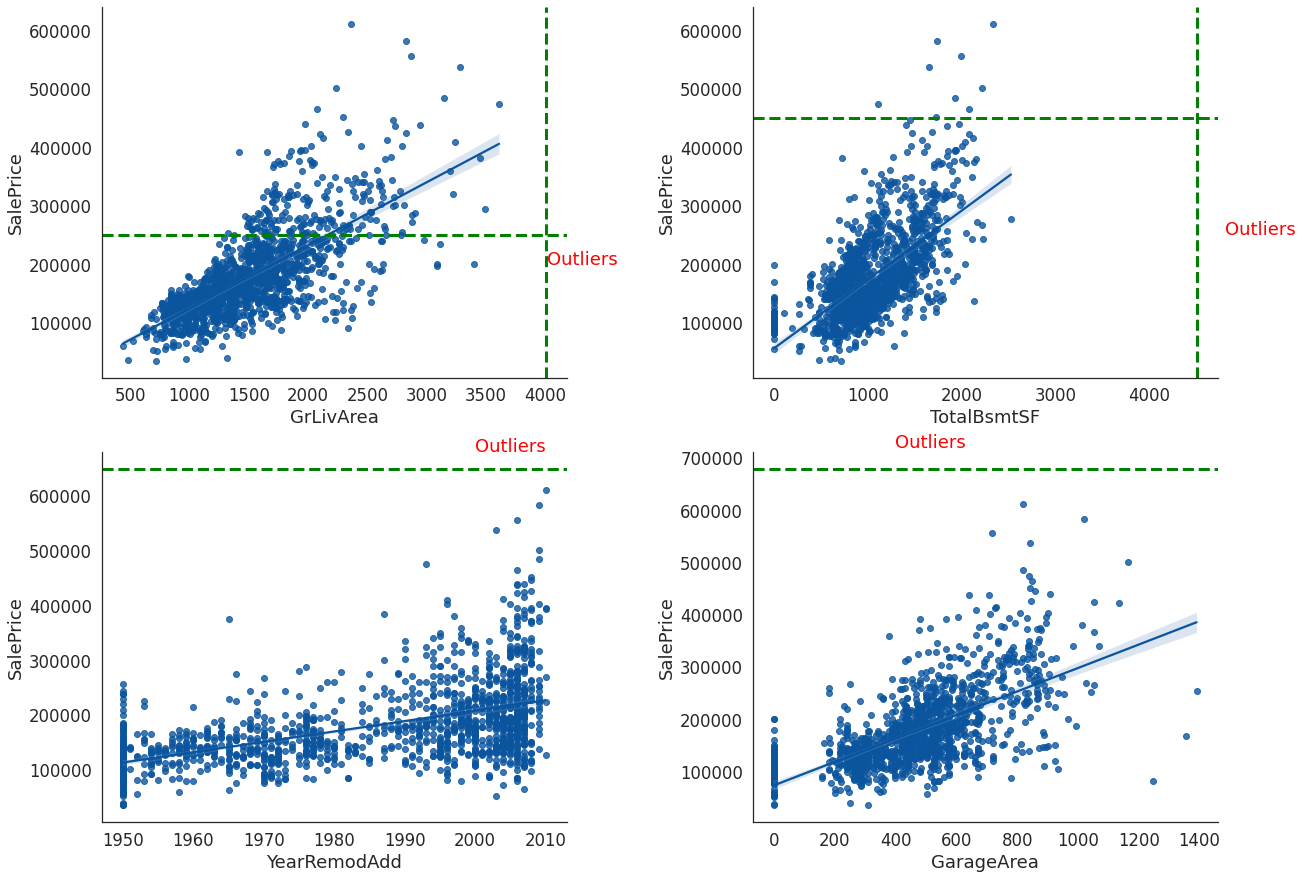

In [45]:
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("Blues_r")
plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.2,wspace=0.4)
plt.subplot(2,2,1)
sns.regplot(data=house_df, x='GrLivArea',y='SalePrice')
plt.axhline(y=250000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4000, color='Green', linestyle='--', linewidth=3)
plt.text(4010, 200000, 'Outliers',color='red')
plt.subplot(2,2,2)
sns.regplot(data=house_df, x='TotalBsmtSF',y='SalePrice')
plt.axhline(y=450000, color='Green', linestyle='--', linewidth=3)
plt.axvline(x=4500, color='Green', linestyle='--', linewidth=3)
plt.text(4800, 250000, 'Outliers',color='red')
plt.subplot(2,2,3)
sns.regplot(data=house_df, x='YearRemodAdd',y='SalePrice')
plt.axhline(y=650000, color='Green', linestyle='--', linewidth=3)
plt.text(2000, 680000, 'Outliers',color='red')
plt.subplot(2,2,4)
sns.regplot(data=house_df, x='GarageArea',y='SalePrice')
plt.axhline(y=680000, color='Green', linestyle='--', linewidth=3)
plt.text(400, 720000, 'Outliers',color='red')
sns.despine()

<span style="color:Blue"> Observation:

Observing the above figures, it can be seen that many of the points previously judged to be outliers have disappeared. Assuming that the outlier has been removed to some extent, let's try another feature engineer.
Of course, we can delete outliers directly by looking at each graph, but in doing so, our model reads a lot of generality. The method using PCA is reasonable and can be used generally.
It can be used for this problem as well as other problems.

Also, as the outliers are removed, the regression line seems to be well-fitted to more general data.

------------------------------------------------------
# Adding New Derived Features using Numerical Feature

Let's create a new derived variable so that our model can learn better.

* TotalBsmtSF: Total square feet of basement area
* GrLivArea: Above grade (ground) living area square feet
* YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
* 1stFlrSF: First Floor square feet 
* 2ndFlrSF: Second floor square feet

## Question 1: Does the combination of underground and above-ground area have a high correlation with the Sale Price?

* TotalBsmtSF: Total square feet of basement area
* GrLivArea: Above grade (ground) living area square feet

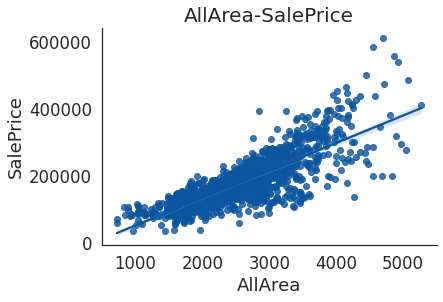

In [46]:
house_df["AllArea"] = house_df.GrLivArea + house_df.TotalBsmtSF
sns.set_style("white")
sns.set_palette("Blues_r")
sns.regplot(data=house_df, x='AllArea',y='SalePrice')
plt.title('AllArea-SalePrice',fontsize=20)
sns.despine()

## Question 2: If you recently remodeled and have a large basement, will your sale price increase?

* TotalBsmtSF: Total square feet of basement area
* YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

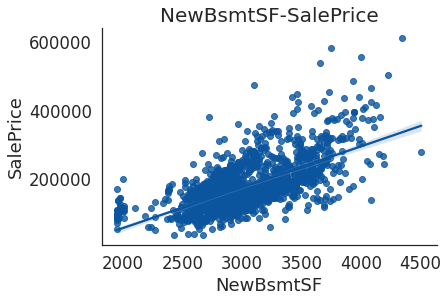

In [47]:
house_df["NewBsmtSF"] = house_df['YearRemodAdd'] + house_df['TotalBsmtSF']
sns.set_style("white")
sns.set_palette("Blues_r")
sns.regplot(data=house_df, x='NewBsmtSF',y='SalePrice')
plt.title('NewBsmtSF-SalePrice',fontsize=20)
sns.despine()

## Question 3: Can the combined area of the 1st and 2nd floors affect the sale price?
* 1stFlrSF: First Floor square feet 
* 2ndFlrSF: Second floor square feet

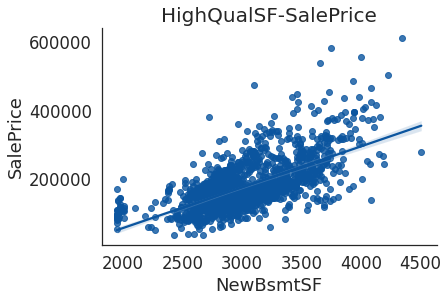

In [48]:
house_df["HighQualSF"] = house_df["1stFlrSF"] + house_df["2ndFlrSF"]
sns.set_style("white")
sns.set_palette("Blues_r")
sns.regplot(data=house_df, x='NewBsmtSF',y='SalePrice')
plt.title('HighQualSF-SalePrice',fontsize=20)
sns.despine()

**Good derivative features come from good questions. Good questions come from a lot of domain-knowledge.**


----------------------------------------------------
# Scaling

There are various scaling methods for numerical features. However, we did log scaling, which is a non-linear scaling of our target. Therefore, other numerical features are also subjected to log scaling.

In [49]:
# Select numerical columns
int_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if 
                house_df[cname].dtype in ['int64']]
float_cols = [cname for cname in house_df.loc[:,:'SaleCondition'].columns if 
                house_df[cname].dtype in ['float64']]

numerical_cols = int_cols + float_cols

First, let's check skewness. A skewness greater than 1 is generally judged to be skewed, so check mainly those greater than 1.

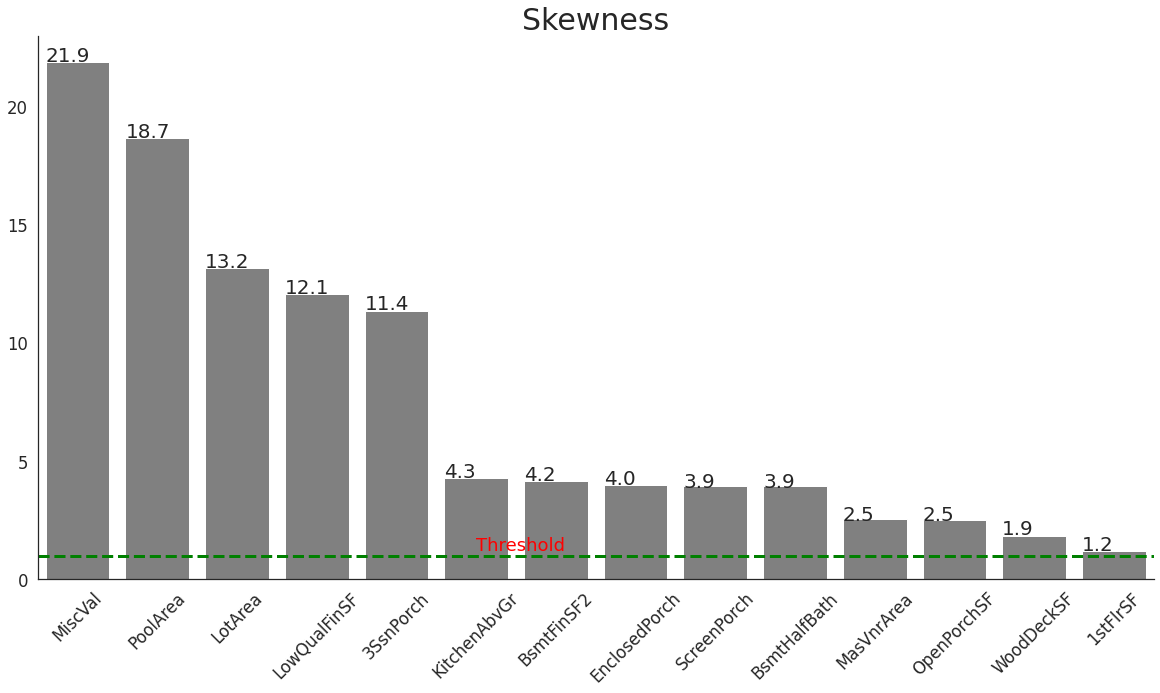

In [50]:
from scipy.stats import skew
plt.figure(figsize=(20, 10))
skew_features = house_df[numerical_cols].apply(lambda x : skew(x))
skew_features = skew_features[skew_features > 1].sort_values(ascending=False)
ax = sns.barplot( x =skew_features.index,y=skew_features.values,color='grey')
for p in ax.patches:
    height = p.get_height().round(1)
    ax.text(p.get_x()+ p.get_width()//2, height, height, ha = 'left', size = 20)
plt.xticks(rotation=45)
plt.text(5, 1.2, 'Threshold',color='red')
plt.axhline(y=1, color='green', linestyle='--', linewidth=3)
plt.title('Skewness',fontsize=30)
sns.despine()

<span style="color:Blue"> Observation:
    
It is conformed that 14 features are skewed. We will do log transformation for these features.

In [51]:
house_df[skew_features.index] = np.log1p(house_df[skew_features.index])

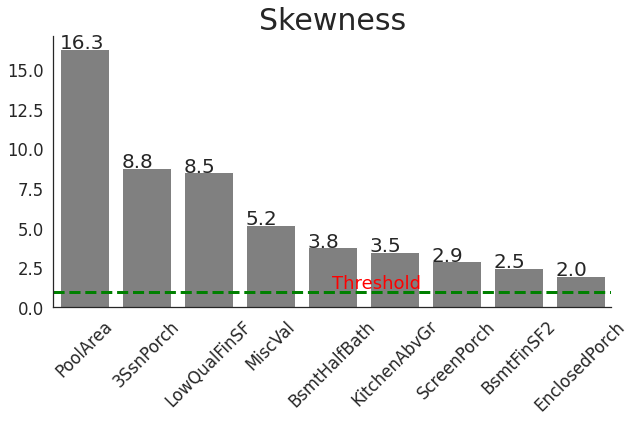

In [52]:
from scipy.stats import skew
plt.figure(figsize=(10, 5))
skew_features = house_df[numerical_cols].apply(lambda x : skew(x))
skew_features = skew_features[skew_features > 1].sort_values(ascending=False)
ax = sns.barplot( x =skew_features.index,y=skew_features.values,color='grey')
for p in ax.patches:
    height = p.get_height().round(1)
    ax.text(p.get_x()+ p.get_width()//2, height, height, ha = 'left', size = 20)
plt.xticks(rotation=45)
plt.axhline(y=1, color='green', linestyle='--', linewidth=3)
plt.text(4, 1.2, 'Threshold',color='red')
plt.title('Skewness',fontsize=30)
sns.despine()

The number of skewed features is reduced from 14 to 9. The remaining 4 skewness was greatly reduced.

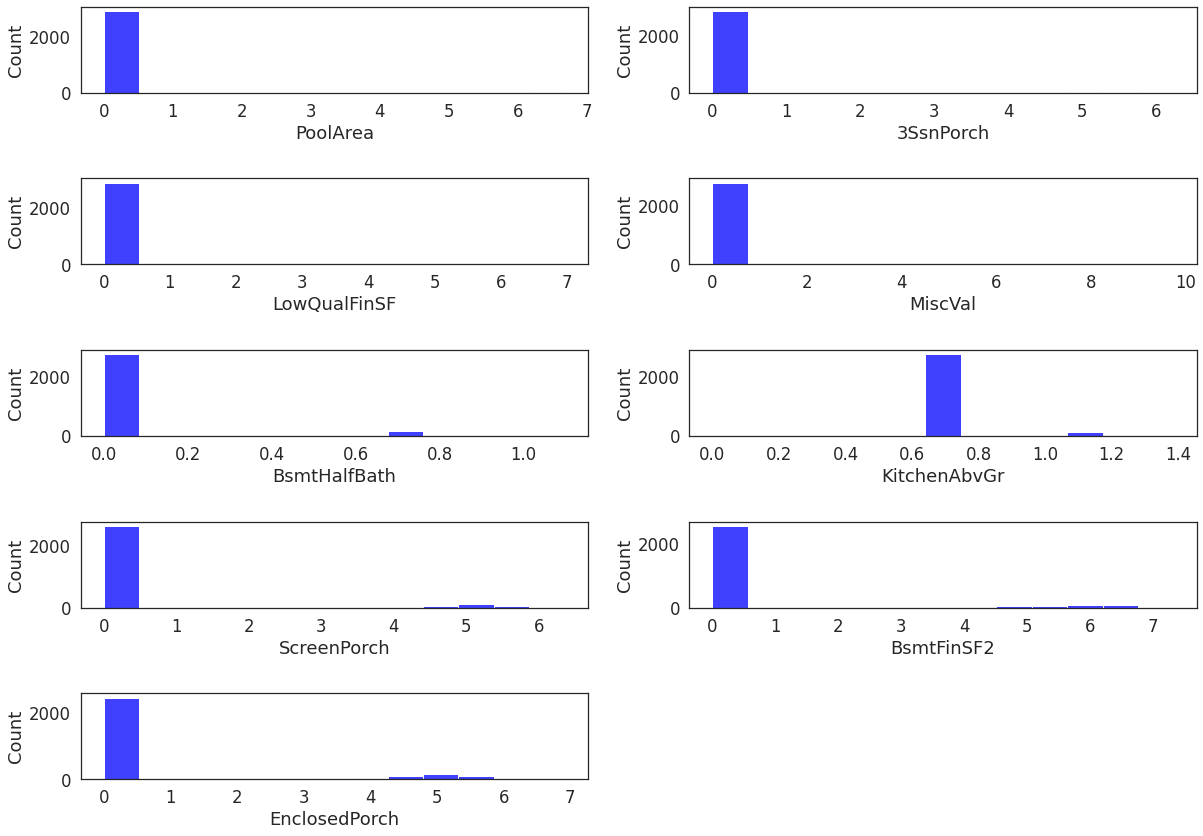

In [53]:
i = 1
sns.set(font_scale = 1.5)
sns.set_style("white")
sns.set_palette("gist_yarg_r")
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=1)
for feature in skew_features.index:
    plt.subplot(10,2,i)
    sns.histplot(house_df[feature], color='blue',palette='Blues_r')
    i = i +1

Some features still have skewness greater than 1, but further improvement seems difficult.

----------------------------------------------------------------
# Doing EDA for Categorical Features

![](https://miro.medium.com/max/1400/1*wYbTRM0dgnRzutwZq63xCg.png)

Picture Credit: https://miro.medium.com

Categorical data can be classified into ordinal data and nominal data. In the case of an ordinal type, there is a difference in importance for each level. This value plays an important role in the case of regression, so encode it with care.

It is difficult to encode categorical features compared to numeric features. For ordinal data, it is more difficult.

In [54]:
categorical_cols = [cname for cname in house_df.columns if
                    house_df[cname].dtype == "object"]

------------------------------------------------------------------------
## Filling missing values

A good way to fill in the missing values of categorical features in the absence of domain-knowledge is to take the most-frequent strategy.

> Imputation is the standard approach, and it usually works well. However, imputed values may be systematically above or below their actual values (which weren't collected in the dataset). Or rows with missing values may be unique in some other way. In that case, your model would make better predictions by considering which values were originally missing.

![](https://i.imgur.com/UWOyg4a.png)

> In this approach, we impute the missing values, as before. And, additionally, for each column with missing entries in the original dataset, we add a new column that shows the location of the imputed entries.
> 
> In some cases, this will meaningfully improve results. In other cases, it doesn't help at all.

Ref: https://www.kaggle.com/alexisbcook/missing-values

## PoolQC: Pool quality 

**Question: Does the lack of pool quality mean that the house does not have a pool? If so, is there a relationship between the missing value and the house price?**

<AxesSubplot:xlabel='HasPoolQC', ylabel='SalePrice'>

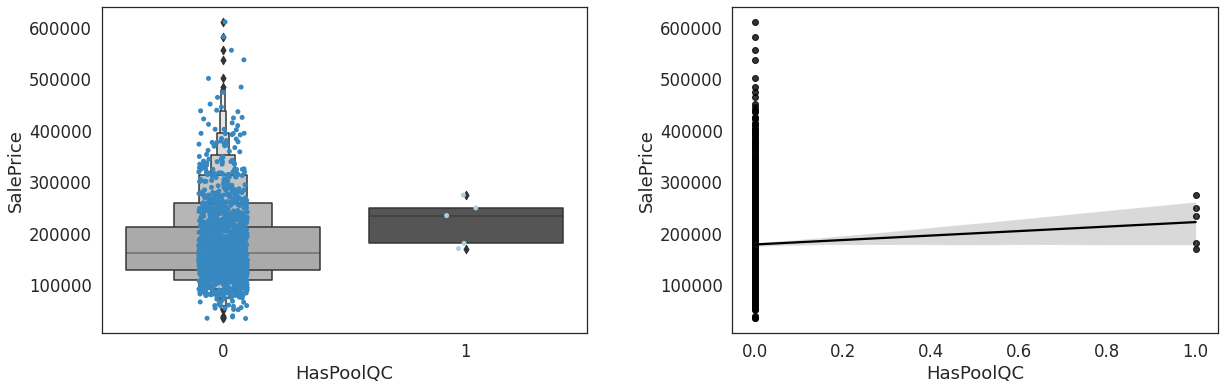

In [55]:
house_df['HasPoolQC'] = house_df['PoolQC'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasPoolQC',y='SalePrice',palette='gist_gray_r')
sns.stripplot(data=house_df, x='HasPoolQC',y='SalePrice',palette='Blues_r')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasPoolQC',y='SalePrice',color='black')

## MiscFeature: Miscellaneous feature not covered in other categories

**Question: Is there a difference in house price with and without miscellaneous features?**

<AxesSubplot:xlabel='HasMiscFeature', ylabel='SalePrice'>

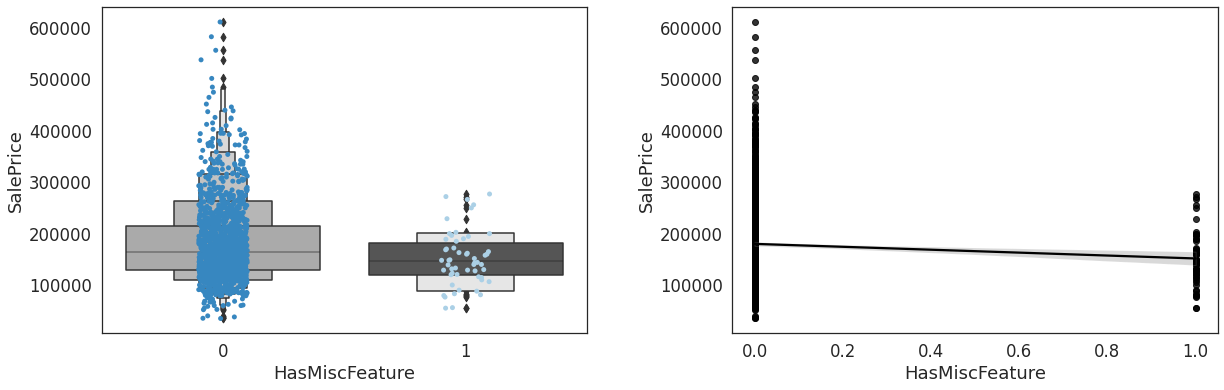

In [56]:
house_df['HasMiscFeature'] = house_df['MiscFeature'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasMiscFeature',y='SalePrice',palette='gist_gray_r')
sns.stripplot(data=house_df, x='HasMiscFeature',y='SalePrice', palette='Blues_r')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasMiscFeature',y='SalePrice',color='black')

## Alley: Type of alley access to property

**Question: Is there a difference in house price with and without Alley access?**

<AxesSubplot:xlabel='HasAlley', ylabel='SalePrice'>

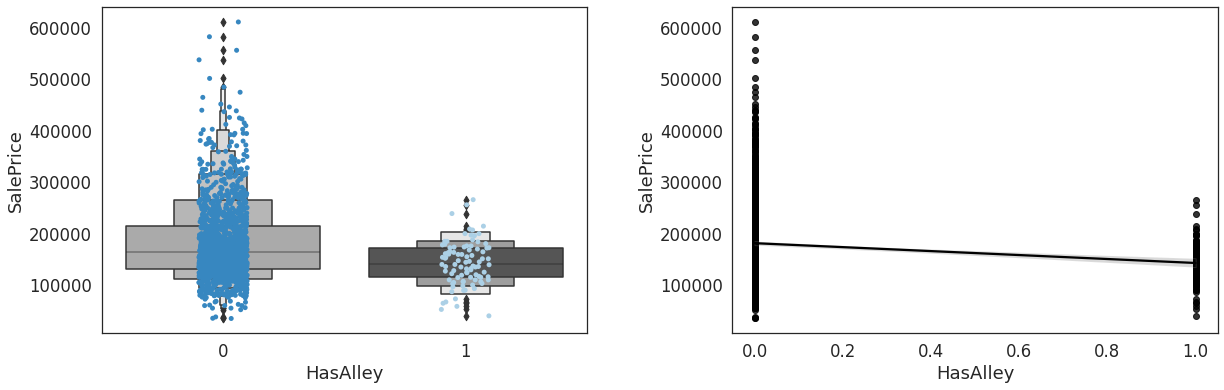

In [57]:
house_df['HasAlley'] = house_df['Alley'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasAlley',y='SalePrice',palette='gist_gray_r')
sns.stripplot(data=house_df, x='HasAlley',y='SalePrice', palette='Blues_r')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasAlley',y='SalePrice',color='black')

## Fence: Fence quality

**Question: Is there a difference in house price with and without fence?**

<AxesSubplot:xlabel='HasFence', ylabel='SalePrice'>

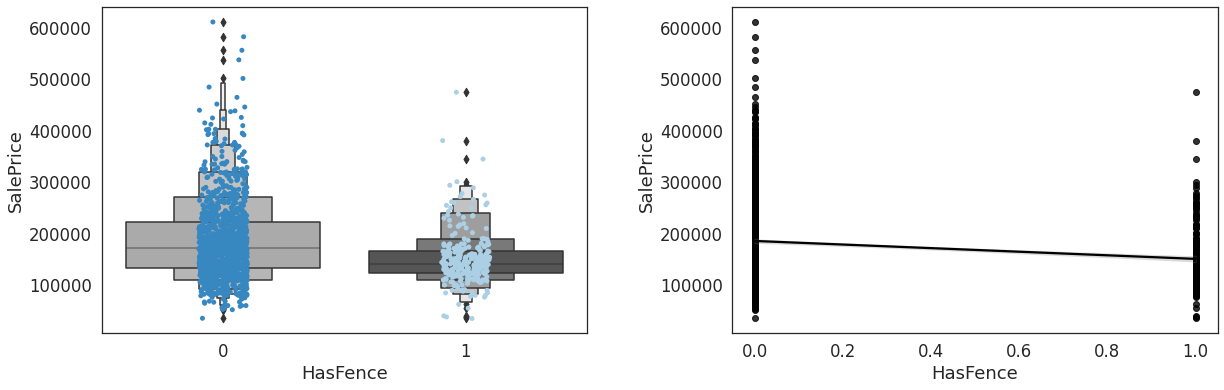

In [58]:
house_df['HasFence'] = house_df['Fence'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasFence',y='SalePrice',palette='gist_gray_r')
sns.stripplot(data=house_df, x='HasFence',y='SalePrice', palette='Blues_r')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasFence',y='SalePrice',color='black')

## FireplaceQu: Fireplace quality

**Question: Is there a difference in house prices with and without Fireplace?**

<AxesSubplot:xlabel='HasFireplaceQu', ylabel='SalePrice'>

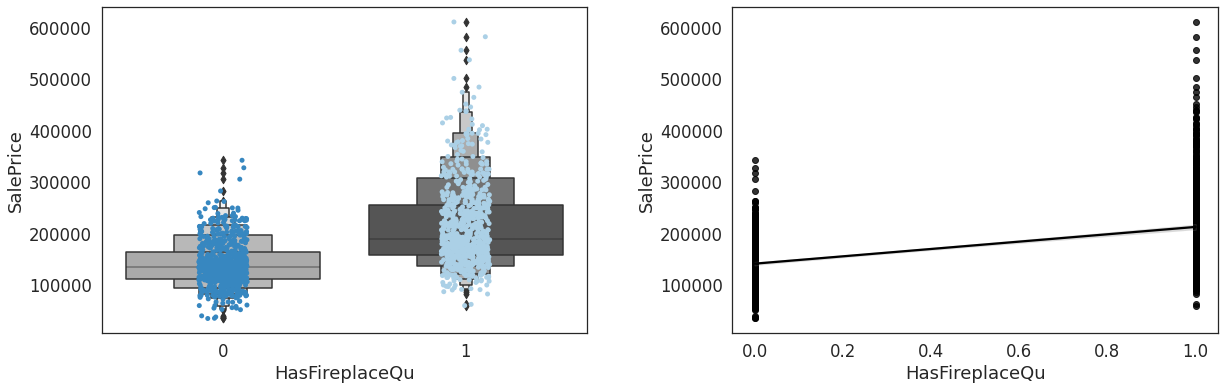

In [59]:
house_df['HasFireplaceQu'] = house_df['FireplaceQu'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasFireplaceQu',y='SalePrice',palette='gist_gray_r')
sns.stripplot(data=house_df, x='HasFireplaceQu',y='SalePrice', palette='Blues_r')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasFireplaceQu',y='SalePrice',color='black')

## Garage Features

**Question: Is there a difference in house price with and without Garage?**

<AxesSubplot:xlabel='HasGarageQual', ylabel='SalePrice'>

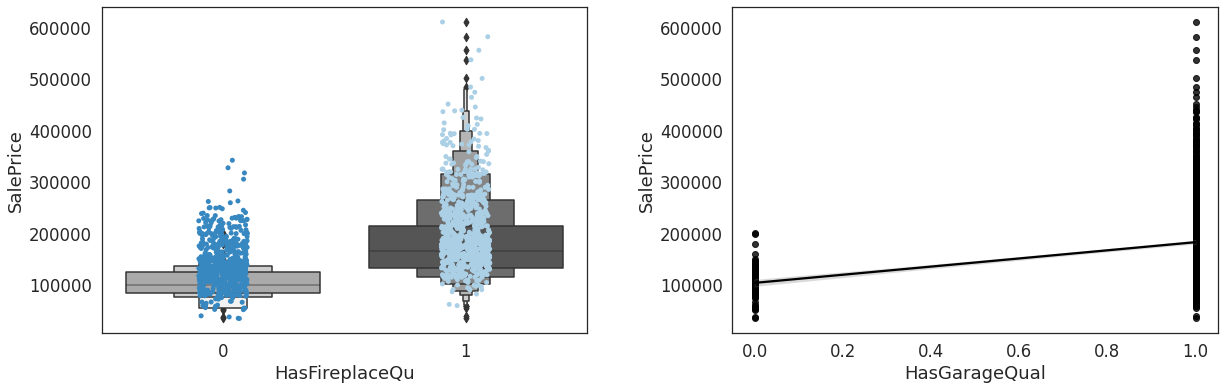

In [60]:
house_df['HasGarageQual'] = house_df['GarageQual'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasGarageQual',y='SalePrice', palette='gist_gray_r')
sns.stripplot(data=house_df, x='HasFireplaceQu',y='SalePrice', palette='Blues_r')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasGarageQual',y='SalePrice',color='black')

## Basement features

**Question: Is there a difference in the house price with and without a Basement?**

<AxesSubplot:xlabel='HasBsmtQual', ylabel='SalePrice'>

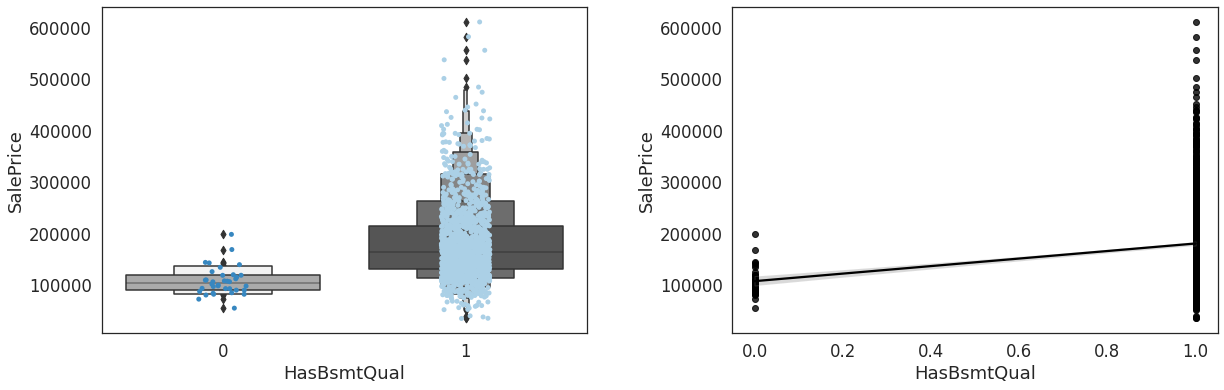

In [61]:
house_df['HasBsmtQual'] = house_df['BsmtQual'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasBsmtQual',y='SalePrice', palette='gist_gray_r')
sns.stripplot(data=house_df, x='HasBsmtQual',y='SalePrice', palette='Blues_r')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasBsmtQual',y='SalePrice',color='black')

## MasVnrType: Masonry veneer type

**Question: Is there a difference in house price with and without Masonry veneer?**

<AxesSubplot:xlabel='HasMasVnrType', ylabel='SalePrice'>

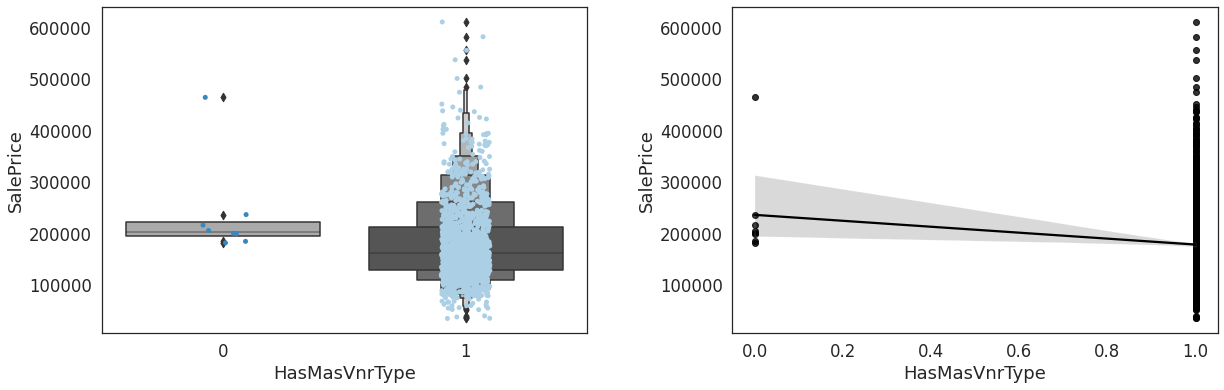

In [62]:
house_df['HasMasVnrType'] = house_df['MasVnrType'].notnull().astype(int)

plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='HasMasVnrType',y='SalePrice', palette='gist_gray_r')
sns.stripplot(data=house_df, x='HasMasVnrType',y='SalePrice', palette='Blues_r')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='HasMasVnrType',y='SalePrice',color='black')

In [63]:
house_df['Alley'] = house_df['Alley'].fillna('missing')
house_df['MasVnrType'] = house_df['MasVnrType'].fillna('None')
house_df['GarageType'] = house_df['GarageType'].fillna('missing')
house_df['GarageCond'] = house_df['GarageCond'].fillna('missing')
house_df['Fence'] = house_df['Fence'].fillna('missing')
house_df['Street'] = house_df['Street'].fillna('missing')
house_df['LotShape'] = house_df['LotShape'].fillna('missing')
house_df['LandContour'] = house_df['LandContour'].fillna('missing')
house_df['BsmtFinType1'] = house_df['BsmtFinType1'].fillna('missing')
house_df['BsmtFinType2'] = house_df['BsmtFinType2'].fillna('missing')
house_df['CentralAir'] = house_df['CentralAir'].fillna('missing')
house_df['MiscFeature'] = house_df['MiscFeature'].fillna('missing')
house_df['Utilities'] = house_df['Utilities'].fillna('missing')
house_df['SaleCondition'] = house_df['SaleCondition'].fillna('missing')
house_df["Functional"] = house_df["Functional"].fillna("Typ")

In [64]:
house_df['MSZoning'] = house_df['MSZoning'].fillna(house_df['MSZoning'].mode()[0])
house_df['PoolQC'] = house_df['PoolQC'].fillna(house_df['PoolQC'].mode()[0])
house_df['BsmtQual'] = house_df['BsmtQual'].fillna(house_df['BsmtQual'].mode()[0])
house_df['BsmtCond'] = house_df['BsmtCond'].fillna(house_df['BsmtCond'].mode()[0])
house_df['FireplaceQu'] = house_df['FireplaceQu'].fillna(house_df['FireplaceQu'].mode()[0])
house_df['GarageFinish'] = house_df['GarageFinish'].fillna(house_df['GarageFinish'].mode()[0])
house_df['GarageQual'] = house_df['GarageQual'].fillna(house_df['GarageQual'].mode()[0])
house_df['BsmtExposure'] = house_df['BsmtExposure'].fillna(house_df['BsmtExposure'].mode()[0])
house_df['Electrical'] = house_df['Electrical'].fillna(house_df['Electrical'].mode()[0])
house_df['Exterior1st'] = house_df['Exterior1st'].fillna(house_df['Exterior1st'].mode()[0])
house_df['Exterior2nd'] = house_df['Exterior2nd'].fillna(house_df['Exterior2nd'].mode()[0])    
house_df['KitchenQual'] = house_df['KitchenQual'].fillna(house_df['KitchenQual'].mode()[0])
house_df['SaleType'] = house_df['SaleType'].fillna(house_df['SaleType'].mode()[0])

-----------------------------------------------------
# Checking Ordinal Features
In some cases, it is easy to judge that there is an order on a commonsense level. However, there are many cases where it is difficult to judge that there is an order. The method used in this notebook to determine whether the features are ordinal or not was determined to have a certain order through visualization. However, if you have real estate knowledge, you will be able to determine the order of each level by classifying ordinal features smarter than me.





------------------------------------------------------------------------
## MSZoning

Identifies the general zoning classification of the sale.

In [65]:
house_df['MSZoning'] = house_df['MSZoning'].replace({'C (all)':1,'RM':2,'RH':3,'RL':4,'FV':5})

## Condition1/Condition2
Proximity to various conditions

In [66]:
house_df['Condition1'] = house_df['Condition1'].replace({'Artery':1,
                                                         'RRAe':1,
                                                         'RRNn':1,
                                                         'Feedr':1,
                                                         'RRNe':1,
                                                         'RRAn':1,
                                                         'Norm':2,
                                                         'PosA':3,
                                                         'PosN':3})

In [67]:
house_df['Condition2'] = house_df['Condition2'].replace({'RRNn':1,
                                                         'Artery':2, 
                                                         'Feedr':2,
                                                         'RRAn':2,
                                                         'RRAe':2,    
                                                         'Norm':2,
                                                         'PosA':3,
                                                         'PosN':3})

## HouseStyle:
HouseStyle: Style of dwelling

In [68]:
def HouseStyleToInt(x):
    if(x=='1.5Unf'):
        r = 0
    elif(x=='SFoyer'):
        r = 1
    elif(x=='1.5Fin'):
        r = 2
    elif(x=='2.5Unf'):
        r = 3
    elif(x=='SLvl'):
        r = 4
    elif(x=='1Story'):
        r = 5
    elif(x=='2Story'):
        r = 6  
    elif(x==' 2.5Fin'):
        r = 7          
    else:
        r = 8
    return r

house_df['HouseStyle'] = house_df['HouseStyle'].apply(HouseStyleToInt)

## MasVnrType
Masonry veneer type

In [69]:
def MasVnrTypeToInt(x):
    if(x=='Stone'):
        r = 3
    elif(x=='BrkFace'):
        r = 2
    elif(x=='BrkCmn'):
        r = 1        
    else:
        r = 0
    return r

house_df['MasVnrType'] = house_df['MasVnrType'].apply(MasVnrTypeToInt)

## Foundation
Type of foundation

In [70]:
foundation_label = {'Slab':1,'BrkTil':2,'Stone':2,'CBlock':3,'Wood':4,'PConc':5}
house_df['Foundation'] = house_df['Foundation'].replace(foundation_label)

## GarageType
Garage location

In [71]:
garagetype_label = {'CarPort':1,'Basment':2,'Detchd':2,'Attchd':3,'2Types':3,'BuiltIn':4}
house_df['GarageType'] = house_df['GarageType'].replace(garagetype_label)

## GarageFinish
Interior finish of the garage

In [72]:
house_df['GarageFinish'] = house_df['GarageFinish'].replace({'Unf':1,'RFn':2,'Fin':3})

## PavedDrive
Paved driveway

In [73]:
house_df['PavedDrive'] = house_df['PavedDrive'].replace({'N':1,'P':2,'Y':3})

## SaleCondition
Condition of sale

In [74]:
salecon_label = {'AdjLand':1,'Abnorml':2,'Family':2,'Alloca':2,'Normal':3,'Partial':4}
house_df['SaleCondition'] = house_df['SaleCondition'].replace(salecon_label)

## Exterior1st / Exterior2nd
Exterior covering on house

In [75]:
ext_lable = {'AsbShng':1,'AsphShn':1,
             'MetalSd':2,'Wd Sdng':2,'WdShing':2, 'Wd Shng':2,'Stucco':2,'CBlock':2,
             'HdBoard':3,'BrkFace':3,'Plywood':3,'Other':3,
             'VinylSd':4,'CemntBd':4,'BrkComm':4,'CmentBd':4,'Brk Cmn':4,
             'Stone':5,'ImStucc':5 }
house_df['Exterior1st'] = house_df['Exterior1st'].replace(ext_lable)
house_df['Exterior2nd'] = house_df['Exterior2nd'].replace(ext_lable)

## BsmtExposure
Refers to walkout or garden level walls

In [76]:
def BsmtExposureToInt(x):
    if(x=='Gd'):
        r = 4
    elif(x=='Av'):
        r = 3
    elif(x=='Mn'):
        r = 2
    elif(x=='No'):
        r = 1
    else:
        r = 0
    return r

house_df['BsmtExposure'] = house_df['BsmtExposure'].apply(BsmtExposureToInt)

## BsmtFinType1
Rating of basement finished area

In [77]:
def BsmtFinType1ToInt(x):
    if(x=='GLQ'):
        r = 6
    elif(x=='ALQ'):
        r = 5
    elif(x=='BLQ'):
        r = 4
    elif(x=='Rec'):
        r = 3   
    elif(x=='LwQ'):
        r = 2
    elif(x=='Unf'):
        r = 1        
    else:
        r = 0
    return r

house_df['BsmtFinType1_int'] = house_df['BsmtFinType1'].apply(BsmtFinType1ToInt)

## Quality Features

* Ex Excellent
* Gd Good
* TA Average/Typical
* Fa Fair
* Po Poor

In [78]:
quality_label = {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}

house_df['ExterQual'] = house_df['ExterQual'].replace(quality_label)
house_df['ExterCond'] = house_df['ExterCond'].replace(quality_label)
house_df['KitchenQual'] = house_df['KitchenQual'].replace(quality_label)
house_df['HeatingQC'] = house_df['HeatingQC'].replace(quality_label)
house_df['BsmtQual'] = house_df['BsmtQual'].replace(quality_label)
house_df['BsmtCond'] = house_df['BsmtCond'].replace(quality_label)
house_df['FireplaceQu'] = house_df['FireplaceQu'].replace(quality_label)
house_df['GarageQual'] = house_df['GarageQual'].replace(quality_label)
house_df['PoolQC'] = house_df['PoolQC'].replace(quality_label)

In [79]:
categorical_cols = [cname for cname in house_df.columns if
                    house_df[cname].dtype == "object"]

--------------------------------------------------------
# Making Derived Features for Categorical Data

## Question 1: Is total house quality correlated with sale price?

<AxesSubplot:xlabel='Total_Home_Quality', ylabel='SalePrice'>

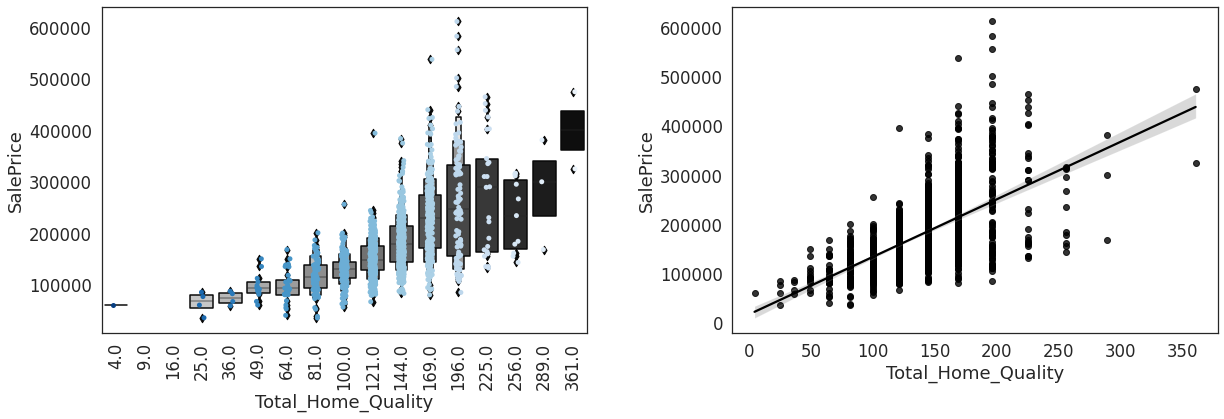

In [80]:
house_df['Total_Home_Quality'] = (house_df['OverallQual'] + house_df['OverallCond'])**2
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='Total_Home_Quality',y='SalePrice',palette='gist_gray_r')
sns.stripplot(data=house_df, x='Total_Home_Quality',y='SalePrice', palette='Blues_r')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='Total_Home_Quality',y='SalePrice',color='black')


## Question 2: Is the total number of bathrooms correlated with the sale price?

<AxesSubplot:xlabel='Total_Bathrooms', ylabel='SalePrice'>

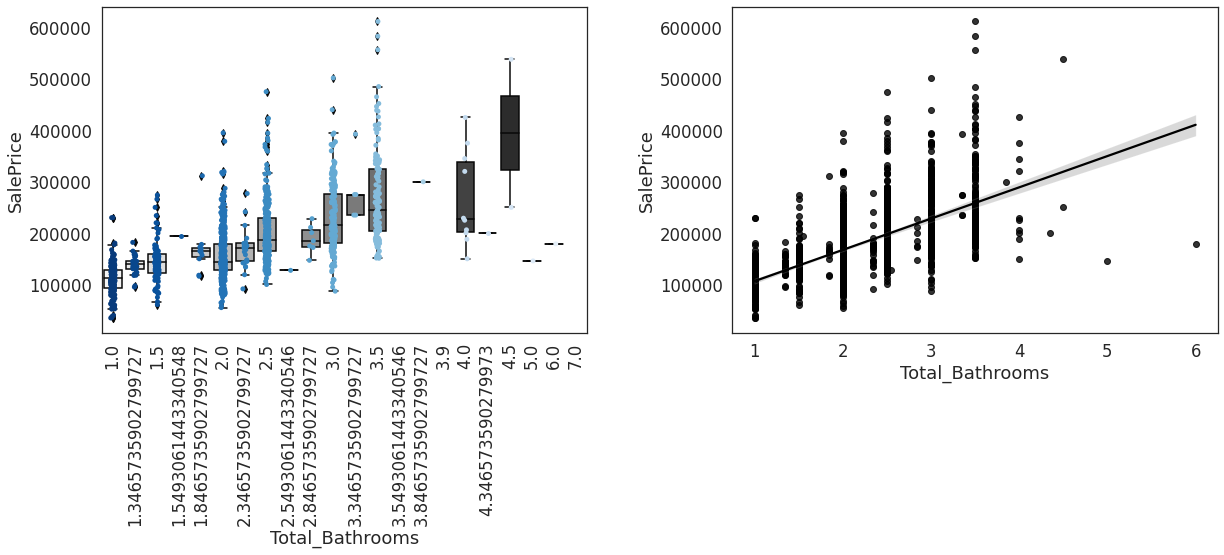

In [81]:
house_df['Total_Bathrooms'] = (house_df['FullBath'] + (0.5 * house_df['HalfBath']) + (house_df['BsmtFullBath'] + (0.5 * house_df['BsmtHalfBath'])))
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxplot(data=house_df, x='Total_Bathrooms',y='SalePrice',palette='gist_gray_r')
sns.stripplot(data=house_df, x='Total_Bathrooms',y='SalePrice', palette='Blues_r')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='Total_Bathrooms',y='SalePrice',color='black')

## Question 3: Can Total Condition Affect Sale Price?

<AxesSubplot:xlabel='total_condition', ylabel='SalePrice'>

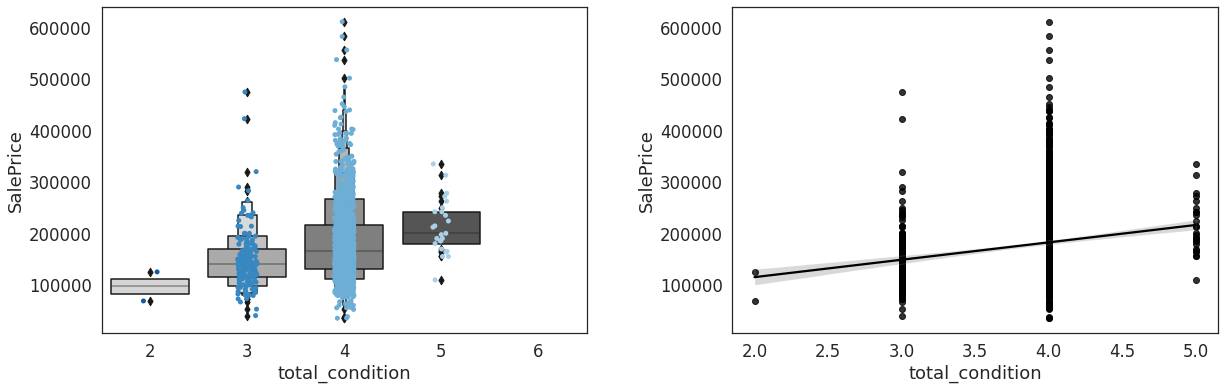

In [82]:
house_df['total_condition'] = house_df['Condition1'] + house_df['Condition2'] 
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
sns.boxenplot(data=house_df, x='total_condition',y='SalePrice',palette='gist_gray_r')
sns.stripplot(data=house_df, x='total_condition',y='SalePrice', palette='Blues_r')
plt.subplot(1,2,2)
sns.regplot(data=house_df, x='total_condition',y='SalePrice',color='black')

## Question 4: Can area per room affect the sale price?

<AxesSubplot:xlabel='SqFtPerRoom', ylabel='SalePrice'>

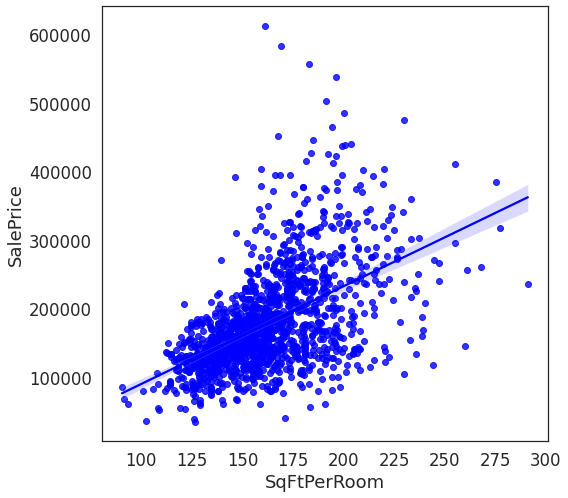

In [83]:
house_df["SqFtPerRoom"] = house_df["GrLivArea"] / (house_df["TotRmsAbvGrd"] +
                                                       house_df["FullBath"] +
                                                       house_df["HalfBath"] +
                                                       house_df["KitchenAbvGr"])
plt.figure(figsize=(8,8))
sns.regplot(data=house_df, x='SqFtPerRoom',y='SalePrice',color='blue')

If we ask a good question and generate good derivatives from it, we will train our model further. 

**However, I'm not a real estate agent, and I'm not very knowledgeable about it.**

---------------------------------------------------------------------------------------
# Checking Dataset before Modeling

## Missing values

<AxesSubplot:>

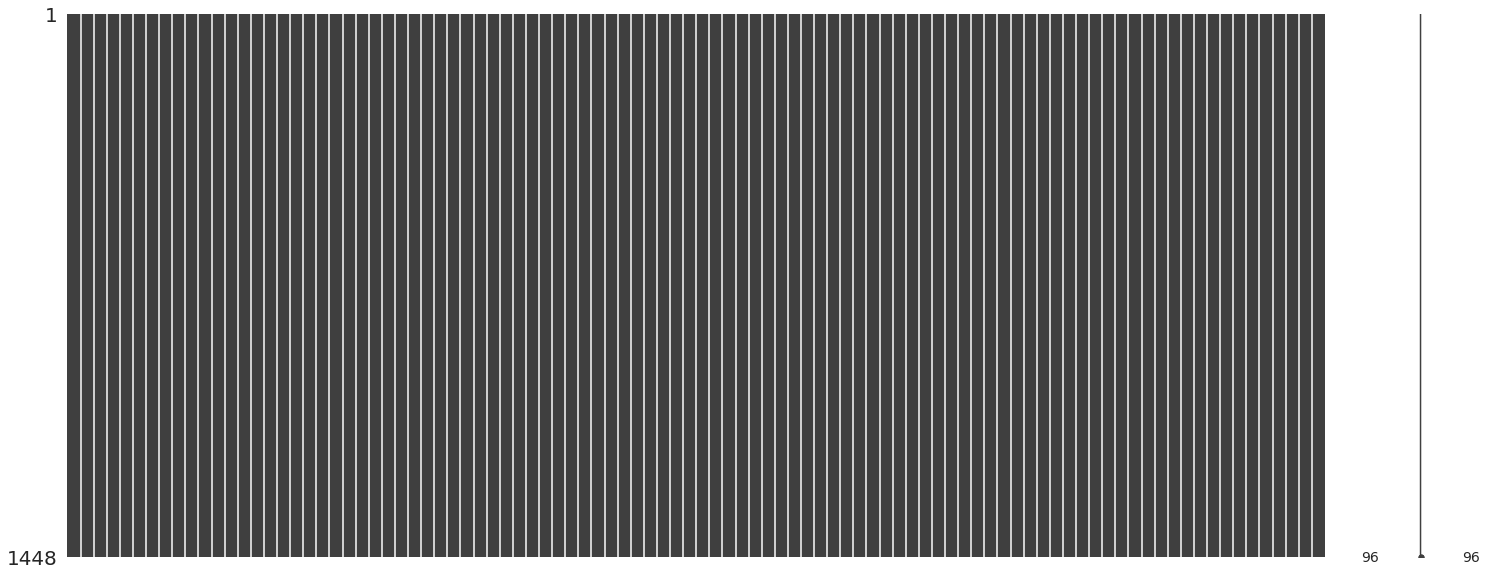

In [84]:
import missingno as msno
msno.matrix(house_df[tr_idx])

## Selecting Features

Text(0.5, 1.0, 'Correlation with SalePrice')

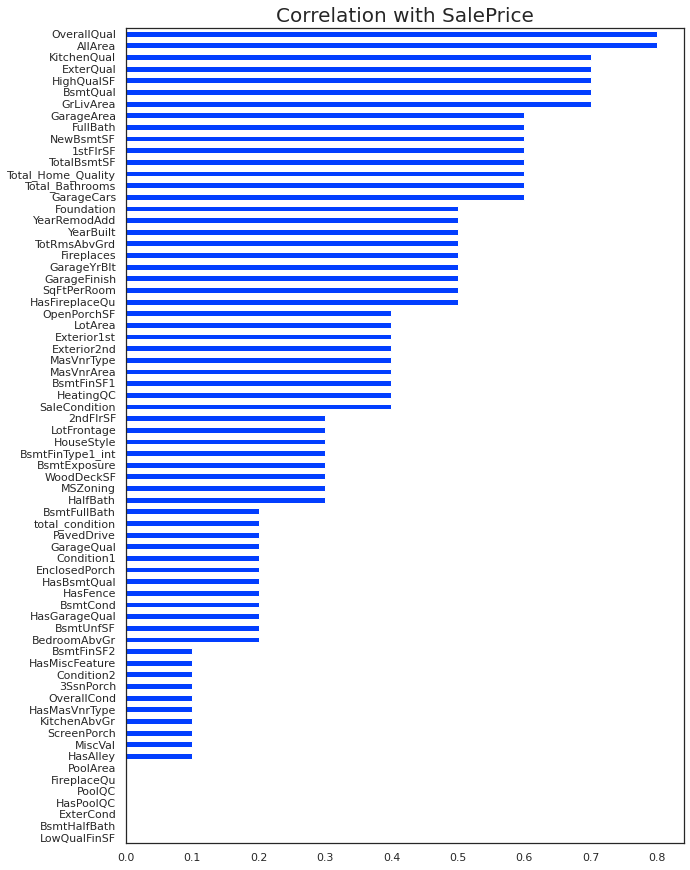

In [85]:
corr=house_df.corr().round(1)
sns.set(font_scale=1)
plt.figure(figsize=(10, 15))
sns.set_style("white")
sns.set_palette("bright")
abs(corr['SalePrice']).sort_values()[:-1].plot.barh()
plt.gca().set_facecolor('#FFFFFF')
plt.title('Correlation with SalePrice',fontsize=20)

<span style="color:Blue"> Observation:

* The newly created derivative variable AllArea feature and house price have a high correlation!
* Pool-related features and fireplaces with many missing values have a low correlation with house price. 


In [86]:
abs_corr = abs(corr['SalePrice']).sort_values()[:-1]
low_corr_list = abs_corr[abs_corr.values == 0].index
house_df.drop(low_corr_list, axis=1,inplace=True)

Let's remove features that have a correlation coefficient of 0 with the sale price!

-----------------
## Encoding nominal data using one-hot encoding.

In [87]:
house_df = pd.get_dummies(house_df, drop_first=True)

## Encoding Target using Log Scaling

In [88]:
house_df['SalePriceCpy'] = np.log1p(house_df['SalePrice'])
house_df.drop('SalePrice',axis=1,inplace=True)
house_df['SalePrice'] = house_df['SalePriceCpy'].copy()
house_df.drop('SalePriceCpy',axis=1,inplace=True)

----------------------------------------------------------------
## Explaining features with partial dependence

> Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest

Ref: https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence

In [89]:
X_train = house_df[tr_idx].drop('SalePrice',axis=1,errors='ignore')
y_train = house_df[tr_idx].pop('SalePrice')
X_test = house_df[~tr_idx].drop('SalePrice',axis=1,errors='ignore')
y_test = house_df[~tr_idx].pop('SalePrice')

In [90]:
high_corr_list = abs_corr[abs_corr.values > 0.5].index
high_corr_list = high_corr_list[::-1]

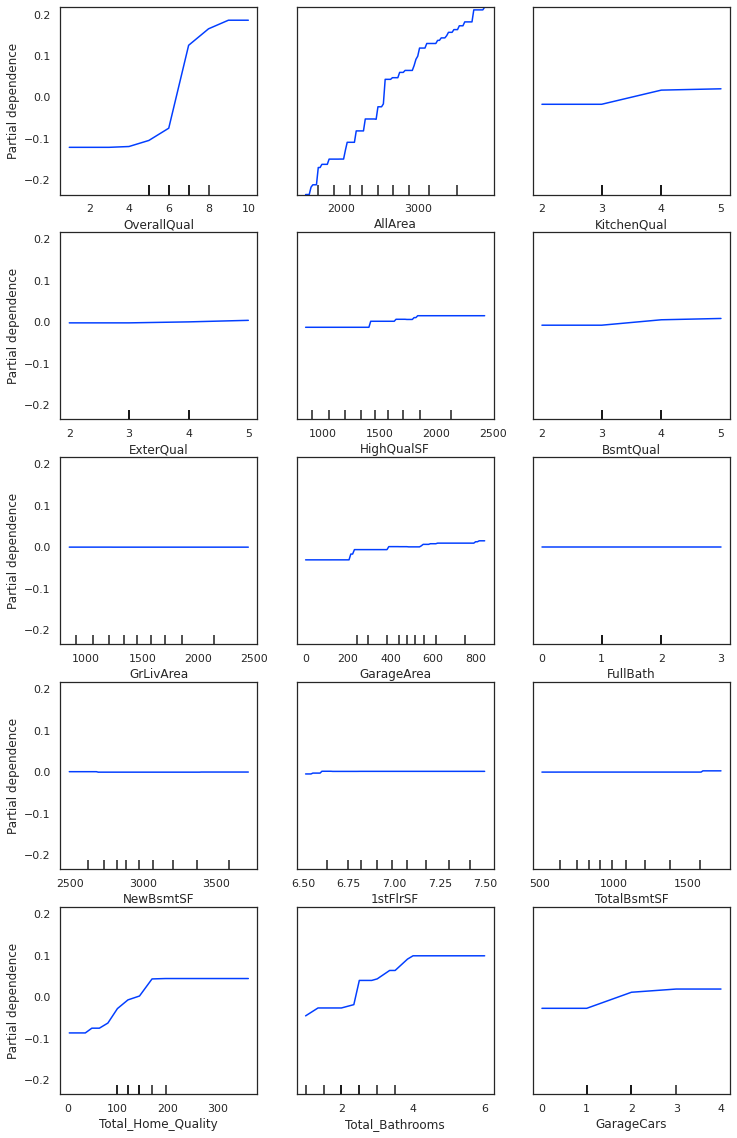

In [91]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence

clf = GradientBoostingRegressor(n_estimators=100).fit(X_train, y_train)
fig,ax = plt.subplots(figsize=(12,20))
plot_partial_dependence(clf, X_train, high_corr_list,ax=ax)

<span style="color:Blue"> Observation:

* When the AllArea feature changes, the value of house price changes the most. That is, the AllArea feature will be one of the most important features in the GradientBoostingRegressor model.
* The importance of features such as ExterQual, BsmtQual, GrLivArea, FullBath, NewBsmtSF, and TotalBsmtSF with high correlation in correlation is not important in the GradientBoostingRegressor model.
* It is advantageous to check feature importance from various viewpoints rather than judging only by correlation. In particular, it can be effective to receive feedback from the designed model. 

In [92]:
all_cols = [cname for cname in house_df.loc[:,:'SaleType_WD'].columns if 
                house_df[cname].dtype in ['int64','float64','uint8']]

-------------------------------------------------------
## Visualizing Training Dataset after Dimension Reduction
The preprocessed training dataset is 202 dimensions. After reducing the dimensions to 2D and 3D, let's check the distribution for each price.

By drawing this picture, we can approximately verify that our preprocessing was done correctly.

### Plotting after dimensionality reduction to 2D

<AxesSubplot:>

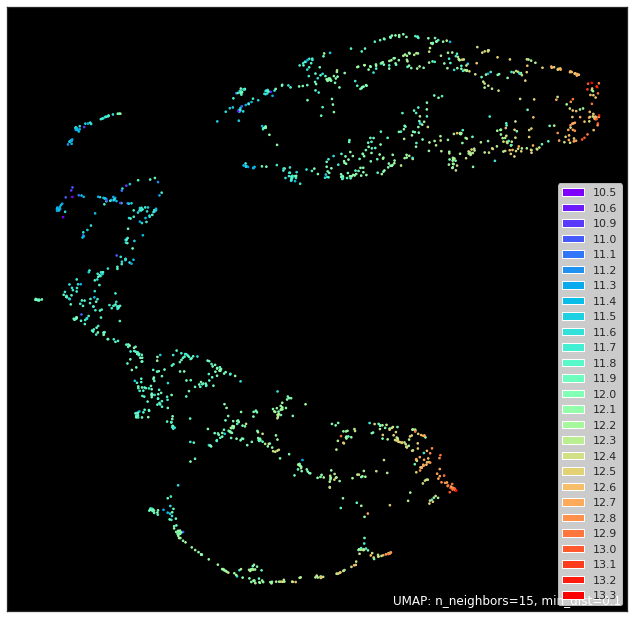

In [93]:
import umap
import umap.plot
mapper = umap.UMAP().fit(X_train)
umap.plot.points(mapper, labels=y_train.round(1), theme='fire')

## Plotting after dimensionality reduction to 3D

In [94]:
import plotly
import plotly.express as px
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(X_train)
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(y_train,name='price')
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='price', labels={'color': 'number'}
)
fig.update_traces(marker_size=1.5)
fig.show()

<class 'numpy.ndarray'>


Even looking at the 3D scaled-down picture, it is difficult to observe the special rules. If we look at it in 202 dimensions, We may be able to find some rules. However, we cannot draw a 202-dimensional picture. 

**Now, all we can do is create a good model and make the model learn well.**

<hr style="border: solid 3px blue;">

# Deep learnig

![](https://cdn.dribbble.com/users/1373613/screenshots/5436349/plexus____-.gif)

Picture Credit: https://cdn.dribbble.com

One of the advantages of DL is that the preprocessing process is simpler than that of classic ML.
And, one of the disadvantages is that it is difficult to explain the model.
In particular, this notebook summarizes the methods for explaining DL.

Compared to classic ML in DL, modeling and hyperparameter selection are more important than preprocessing.

## Preprecessing for DL

Compared to Classic ML, the process of Feature Engineering is simple.

**In most cases, the following steps are required.**
* Handling missing values
* Encoding for categorical features (one-hot encoding is mainly used).
* Standard or Min-Max Scaling

In [95]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [96]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train.values).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test.values).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

## Setting Hyperparameters

In [97]:
batch_size = 50
num_epochs = 400
learning_rate = 0.01
size_hidden1 = 600
size_hidden2 = 300
size_hidden3 = 300
size_hidden4 = 10
size_hidden5 = 1
input_size = 202

## Modeling HouseNet

In [98]:
class HouseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(input_size, size_hidden1)
        self.act1 = nn.ReLU()
        self.BatchNorm1d1 = nn.BatchNorm1d(size_hidden1, affine=False)
        self.drop1 = nn.Dropout(0.3)
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.act2 = nn.ReLU()
        self.BatchNorm1d2 = nn.BatchNorm1d(size_hidden2, affine=False)
        self.drop2 = nn.Dropout(0.3)
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.act3 = nn.ReLU()
        self.BatchNorm1d3 = nn.BatchNorm1d(size_hidden3, affine=False)
        self.drop3 = nn.Dropout(0.3)
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)
        self.act4 = nn.ReLU()
        self.BatchNorm1d4 = nn.BatchNorm1d(size_hidden4, affine=False)
        self.lin5 = nn.Linear(size_hidden4, size_hidden5)

    def forward(self, input):
        lin1_out = self.lin1(input)
        lin1_out = self.BatchNorm1d1(lin1_out)
        lin1_out = self.drop1(lin1_out)
        act1_out = self.act1(lin1_out)
        lin2_out = self.lin2(act1_out)
        lin2_out = self.BatchNorm1d2(lin2_out)
        lin2_out = self.drop2(lin2_out)
        act2_out = self.act2(lin2_out)
        lin3_out = self.lin3(act2_out)
        lin3_out = self.BatchNorm1d3(lin3_out)
        lin3_out = self.drop3(lin3_out)
        act3_out3 = self.act3(lin3_out)
        lin4_out = self.lin4(act3_out3)
        lin4_out = self.BatchNorm1d4(lin4_out)
        act4_out4 = self.act4(lin4_out)
        lin5_out = self.lin5(act4_out4)
        return lin5_out

## Training HouseNet

![](https://machinelearningknowledge.ai/wp-content/uploads/2019/10/Backpropagation.gif)

Picture Credit: https://machinelearningknowledge.ai

> In the case of DL, the weight of each neuron (node) is adjusted through error backpropagation. This process is the most important part of the process of learning. Through this gradient descent process, we can understand which neurons play an important role and which features are important.

In [99]:
model = HouseNet()
model.train()

HouseNet(
  (lin1): Linear(in_features=202, out_features=600, bias=True)
  (act1): ReLU()
  (BatchNorm1d1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (lin2): Linear(in_features=600, out_features=300, bias=True)
  (act2): ReLU()
  (BatchNorm1d2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (lin3): Linear(in_features=300, out_features=300, bias=True)
  (act3): ReLU()
  (BatchNorm1d3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (drop3): Dropout(p=0.3, inplace=False)
  (lin4): Linear(in_features=300, out_features=10, bias=True)
  (act4): ReLU()
  (BatchNorm1d4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (lin5): Linear(in_features=10, out_features=1, bias=True)
)

In [100]:
criterion = nn.MSELoss(reduction='sum')

![](https://blog.paperspace.com/content/images/2018/06/optimizers7.gif)

Picture Credit: https://blog.paperspace.com

> * Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.
> * Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
> * Adam is relatively easy to configure where the default configuration parameters do well on most problems.

Ref: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [101]:
def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.Adam(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

In [102]:
train(model)

Epoch [1]/[400] running accumulative loss across all batches: 103547.144
Epoch [21]/[400] running accumulative loss across all batches: 428.623
Epoch [41]/[400] running accumulative loss across all batches: 225.638
Epoch [61]/[400] running accumulative loss across all batches: 180.504
Epoch [81]/[400] running accumulative loss across all batches: 112.318
Epoch [101]/[400] running accumulative loss across all batches: 82.944
Epoch [121]/[400] running accumulative loss across all batches: 61.784
Epoch [141]/[400] running accumulative loss across all batches: 49.649
Epoch [161]/[400] running accumulative loss across all batches: 45.461
Epoch [181]/[400] running accumulative loss across all batches: 36.872
Epoch [201]/[400] running accumulative loss across all batches: 31.054
Epoch [221]/[400] running accumulative loss across all batches: 26.591
Epoch [241]/[400] running accumulative loss across all batches: 27.569
Epoch [261]/[400] running accumulative loss across all batches: 22.827
Epoc

In [103]:
model.eval()
outputs = model(X_test).squeeze()

In [104]:
preds_test_nn = np.expm1(outputs.detach().numpy())

In [105]:
submission_data.loc[:,'SalePrice'] = preds_test_nn
submission_data.to_csv('submission_nn.csv', index=False)

In [106]:
submission_data.head(5)

Id      SalePrice
0  1461  125677.671875
1  1462  161046.140625
2  1463  177081.765625
3  1464  176654.843750
4  1465  174889.718750

-------------------------------------------------------------
# Let's explain Neural Netwok

![](https://media0.giphy.com/media/1iUixiLvgO2jyBtZoy/giphy.gif)

Picture Credit: https://media0.giphy.com/media


**neural network/neurons**

> A neural network is a network or circuit of neurons, or in a modern sense, an artificial neural network, composed of artificial neurons or nodes. Thus a neural network is either a biological neural network, made up of biological neurons, or an artificial neural network, for solving artificial intelligence (AI) problems. The connections of the biological neuron are modeled in artificial neural networks as weights between nodes. A positive weight reflects an excitatory connection, while negative values mean inhibitory connections. All inputs are modified by a weight and summed. This activity is referred to as a linear combination. Finally, an activation function controls the amplitude of the output. For example, an acceptable range of output is usually between 0 and 1, or it could be −1 and 1

Ref: https://en.wikipedia.org/wiki/Neural_network

# What is Integrated Gradients
Integrated gradients represents the integral of gradients with respect to inputs along the path from a given baseline to input. The integral can be approximated using a Riemann Sum or Gauss Legendre quadrature rule. Formally, it can be described as follows:

![](https://captum.ai/img/IG_eq1.png)

Ref: https://captum.ai/img

In this case, let's check what features are important for making a decision in our designed neural network.

In [107]:
ig = IntegratedGradients(model)
ig_attr_test = ig.attribute(X_test, n_steps=50)

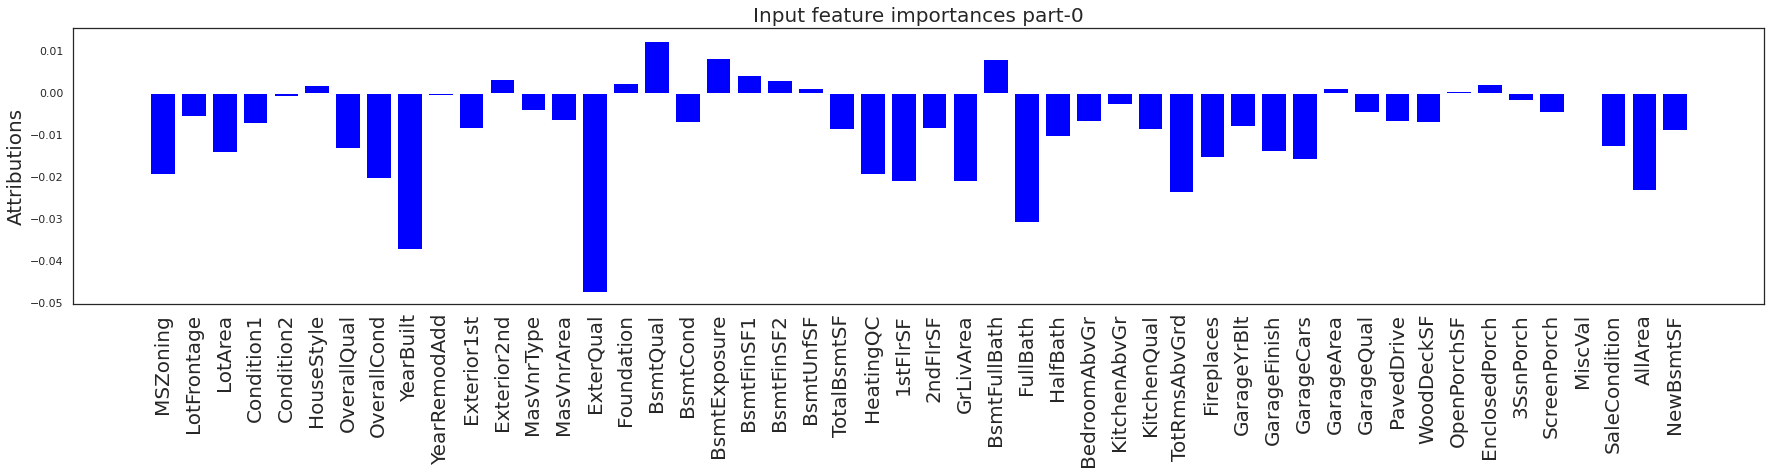

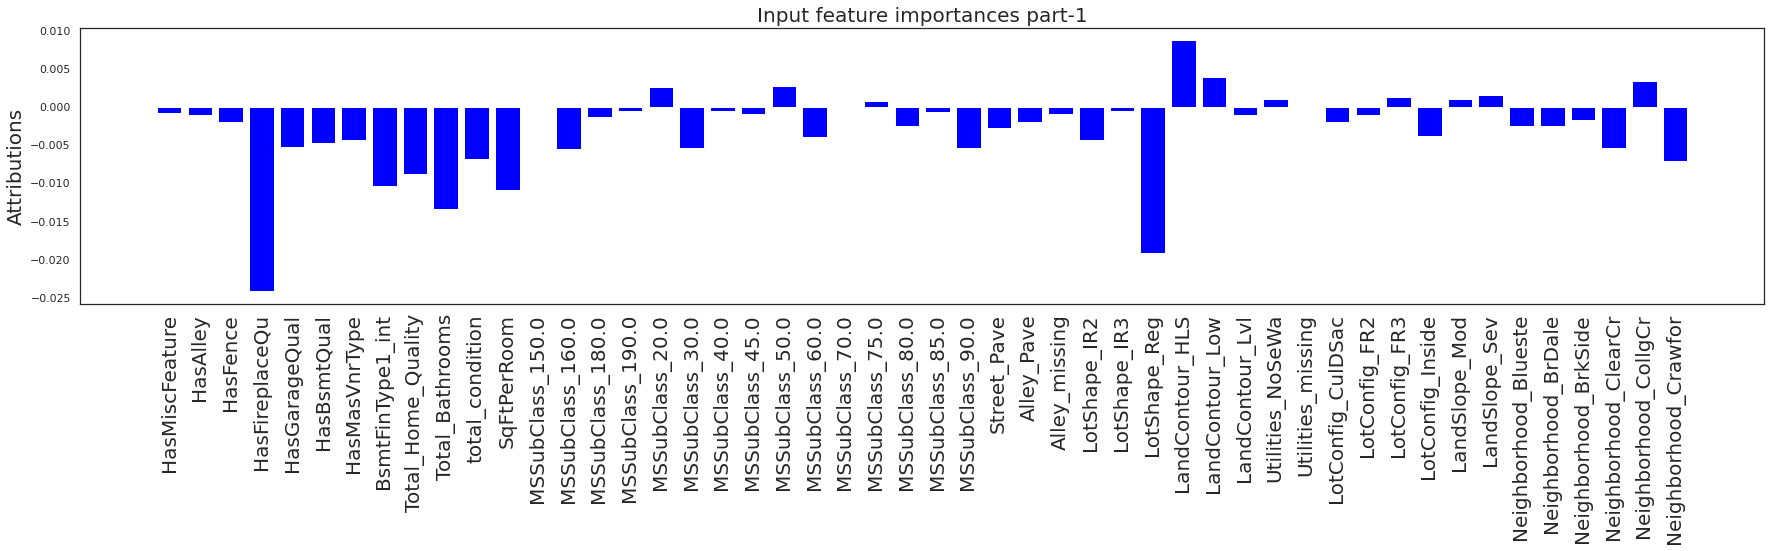

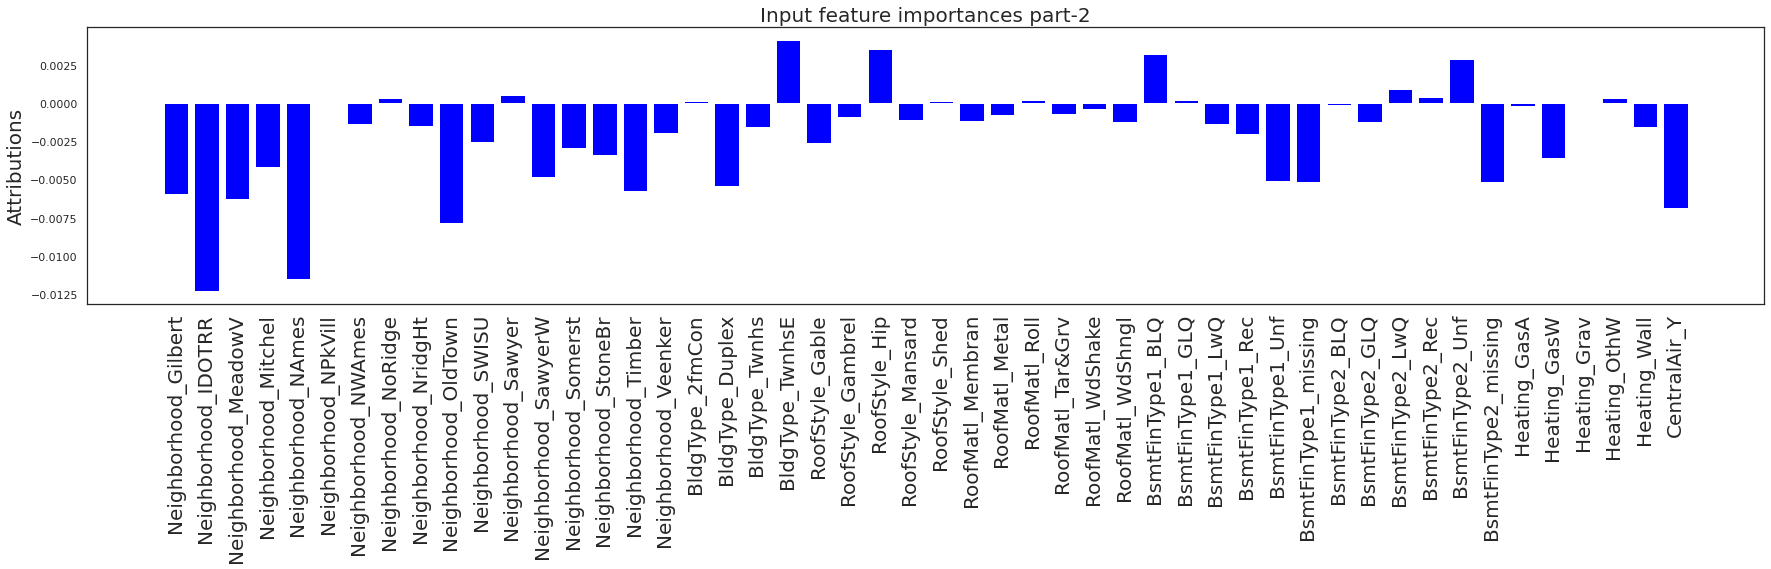

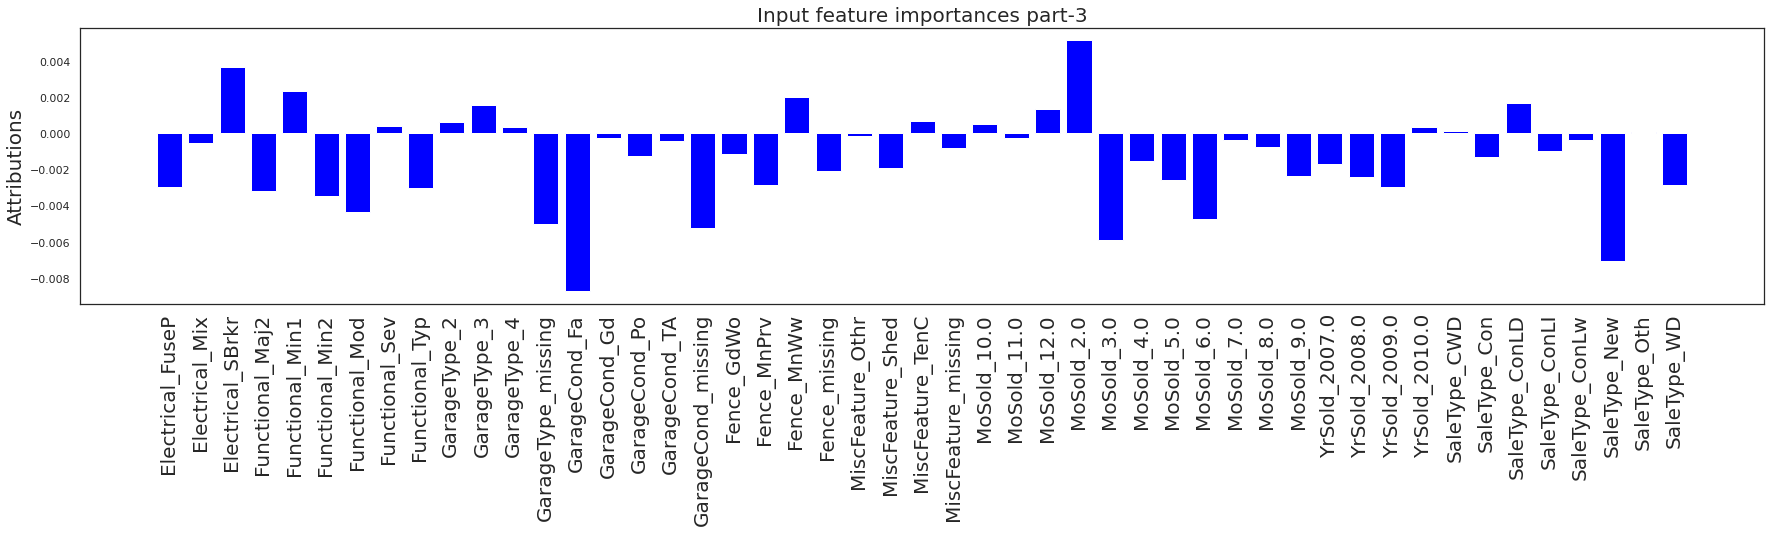

In [108]:
# prepare attributions for visualization
x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: all_cols[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

FONT_SIZE = 20
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

start = 0
width = 50
for i in range(4):
    plt.figure(figsize=(25, 5))
    ax = plt.subplot()
    ax.set_title(f'Input feature importances part-{i}')
    ax.set_ylabel('Attributions')
    ax.bar(x_axis_data[start:start+width], ig_attr_test_norm_sum[start:start+width], align='center', color='blue')
    ax.autoscale_view()
    plt.tight_layout()

    ax.set_xticks(x_axis_data[start:start+width])
    ax.set_xticklabels(x_axis_data_labels[start:start+width],fontsize=20)
    start = start + width + 1
    plt.xticks(rotation=90)
    plt.show()   


<span style="color:Blue"> Observation:
    
Looking at the figure above, the neural network has determined that the following features are important.

* YearBuilt, YearRemodAdd, GarageYrBlt, NewBsmtSF, Total_Home_Quaility, SqFtPerRoom, HeatingGasW, CentralAir_Y, Functional_Typ, GarageCond_TA

----------------------------------------------------------
# Attributing to the layers and comparing with model weights

In [109]:
# Compute the attributions of the output with respect to the inputs of the 5th linear layer
lc = LayerConductance(model, model.lin5)
lc_attr_test = lc.attribute(X_test, n_steps=100, attribute_to_layer_input=True)

# shape: test_examples x size_hidden
lc_attr_test = lc_attr_test[0]

# weights from 5th linear layer
# shape: size_hidden5 x size_hidden4
lin5_weight = model.lin5.weight

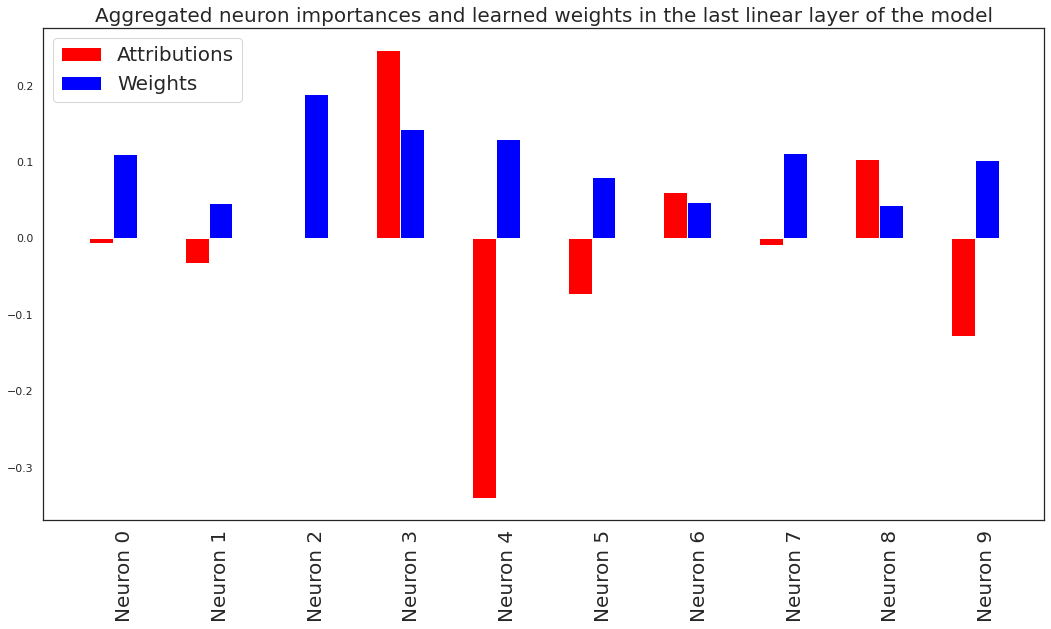

In [110]:
plt.figure(figsize=(15, 8))

x_axis_data = np.arange(lc_attr_test.shape[0])

y_axis_lc_attr_test = lc_attr_test.detach().numpy()
y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)

y_axis_lin5_weight = lin5_weight[0].detach().numpy()
y_axis_lin5_weight = y_axis_lin5_weight / np.linalg.norm(y_axis_lin5_weight, ord=1)

width = 0.25
legends = ['Attributions','Weights']
x_axis_labels = [ 'Neuron {}'.format(i) for i in range(len(y_axis_lin5_weight))]

ax = plt.subplot()
ax.set_title('Aggregated neuron importances and learned weights in the last linear layer of the model')

ax.bar(x_axis_data + width, y_axis_lc_attr_test, width, align='center', color='red')
ax.bar(x_axis_data + 2 * width, y_axis_lin5_weight, width, align='center', color='blue')
plt.legend(legends, loc=2, prop={'size': 20})
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_labels,fontsize=20)
plt.xticks(rotation=90)
plt.show()

We normalize and visualize the attributions and learned model weights for all 10 neurons in the fifth hidden layer.

The weights represent the weight matrix of the fifth linear layer. The attributions are computed with respect to the inputs of the fifth linear layer.

<hr style="border: solid 3px blue;">

# Machine Learning (Ensemble)

![](https://media0.giphy.com/media/26xBvMWzk7FQr54Sk/giphy.gif)

Picture Credit: https://media0.giphy.com



In [111]:
from pycaret.regression import *

## Setting Up

> This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function. It takes two mandatory parameters: data and target. All the other parameters are optional.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [112]:
reg = setup(data = house_df[tr_idx],
            target = 'SalePrice',
            normalize = False,
            preprocess = False,
            numeric_features = all_cols,
            verbose = False,
            silent = True)

## Creating Models

> This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

In [113]:
catboost = create_model('catboost')
br = create_model('br')
ridge = create_model('ridge')
gbr = create_model('gbr')
lightgbm = create_model('lightgbm')

## Tuning Hyperparameters

> This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html

We will use the optuna library to tune the hyperparameters.

In [114]:
tuned_catboost = tune_model(catboost,early_stopping=True,optimize='RMSE',search_library='optuna')
tuned_br = tune_model(br,early_stopping=True,optimize='RMSE',search_library='optuna')
tuned_gbr = tune_model(gbr,early_stopping=True,optimize='RMSE',search_library='optuna')
tuned_ridge = tune_model(ridge,early_stopping=True,optimize='RMSE',search_library='optuna')
tuned_lightgbm = tune_model(lightgbm,early_stopping=True,optimize='RMSE',search_library='optuna')

## Interpreting Models

> SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

Ref: https://shap.readthedocs.io/en/latest/index.html

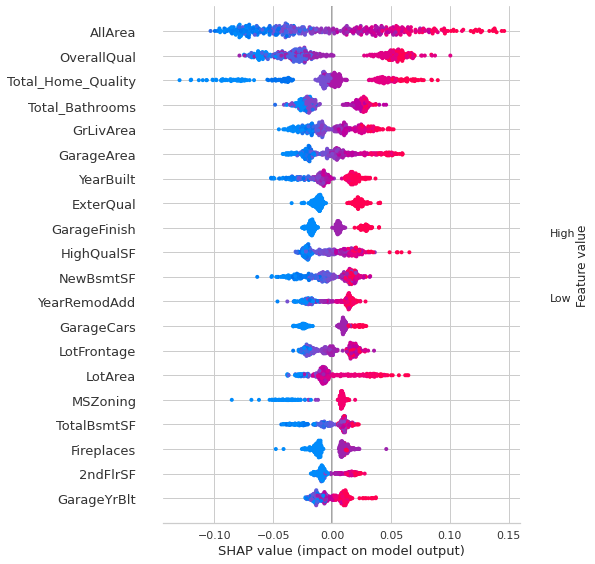

In [115]:
interpret_model(tuned_catboost)

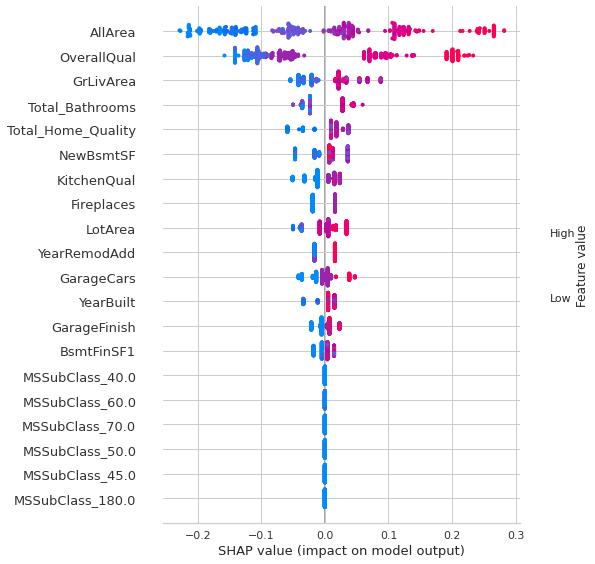

In [116]:
interpret_model(tuned_lightgbm)

<span style="color:Blue"> Observation:

* Newly created derived variables play an important role in model learning.
* When the models are different, the feature importance is also slightly different. This diversity is the power of ensemble. 

-------------------------------------------------------------------------------
# Soft Voting

![](https://miro.medium.com/max/806/1*bliKQZGPccS7ho9Zo6uC7A.jpeg)

Picture Credit: https://miro.medium.com

In [117]:
blend_soft = blend_models(estimator_list = [catboost,br,ridge,gbr,lightgbm], 
                          optimize = 'RMSE')

------------------------------------
# Finalizing the last model
> This function trains a given estimator on the entire dataset including the holdout set.

Ref: https://pycaret.readthedocs.io/en/latest/api/classification.html


**The blend model seems to be stable. Let's use this model as our final model.**

In [118]:
final_model = finalize_model(blend_soft)

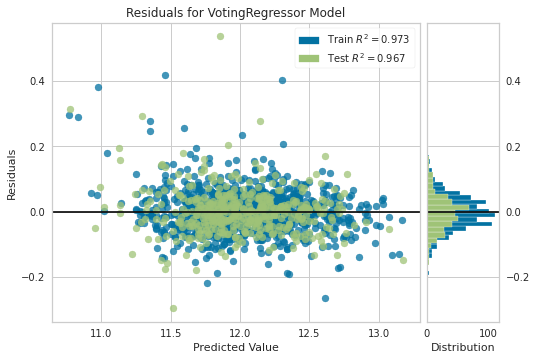

In [119]:
plot_model(final_model, plot='residuals')

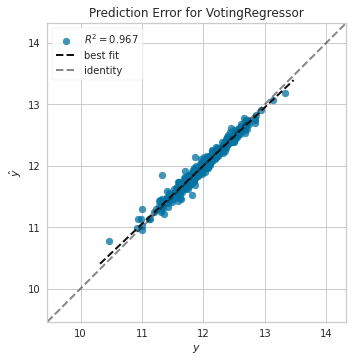

In [120]:
plot_model(final_model, plot='error')

<span style="color:Blue"> Observation:

* R squared is 97.5%. This means that our model can explain the dataset by 97.5%. 

> **R-squared** is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.
> 
> The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model. Or:
> 
> * R-squared = Explained variation / Total variation
> 
> R-squared is always between 0 and 100%:
> 
> * 0% indicates that the model explains none of the variability of the response data around its mean.
> * 100% indicates that the model explains all the variability of the response data around its mean.
> In general, the higher the R-squared, the better the model fits your data. However, there are important conditions for this guideline that I’ll talk about both in this post and my next post.

Ref: https://blog.minitab.com/en

-------------------------------------------
# Submitting Result

We trained by taking the logarithm of the target values. Therefore, since predicted values ​​are also in the logarithm state, they take the process of converting back to actual values ​​through the exponential function.

In [121]:
X_test_df = house_df[~tr_idx].drop('SalePrice',axis=1)
preds_test_pycaret = np.expm1(final_model.predict(X_test_df))

In [122]:
submission_data.loc[:,'SalePrice'] = preds_test_pycaret
submission_data.to_csv('submission.csv', index=False)

In [123]:
submission_data.head(5)

Id      SalePrice
0  1461  120423.634844
1  1462  158082.237016
2  1463  182024.599426
3  1464  190819.123382
4  1465  192519.916457

<hr style="border: solid 3px blue;">